https://www.arundo.com/articles/adtk-open-source-time-series-anomaly-detection-in-python

In [1]:
!uv pip install adtk

Resolved 22 packages in 11.63s                                       
Prepared 4 packages in 5.40s                                             
Installed 4 packages in 47ms                                
 + adtk==0.6.2
 + patsy==0.5.6
 + statsmodels==0.14.4
 + tabulate==0.9.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# служебные функции
from adtk.data import validate_series
from adtk.visualization import plot
# Статистические методы детектирования точечных аномалий
from adtk.detector import ThresholdAD
from adtk.detector import QuantileAD
from adtk.detector import InterQuartileRangeAD
from adtk.detector import GeneralizedESDTestAD
# Статистические методы детектирования групповых аномалий
from adtk.detector import PersistAD
from adtk.detector import LevelShiftAD
from adtk.detector import VolatilityShiftAD
# методы на основе декомпозиции временного ряда и авторегрессии
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD
# Методы на основе кластеризации - неконтролируемое обучение
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans
# Методы на основе плотности
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
# Методы на основе регрессии - контролируемое обучение
from adtk.detector import RegressionAD
from sklearn.linear_model import LinearRegression
# Методы на основе понижения размерности
from adtk.detector import PcaAD
# кастомизация
from adtk.detector import CustomizedDetectorHD

In [14]:
import time
from datetime import datetime, timedelta
# from pybit.unified_trading import HTTP
import warnings
import talib

In [3]:
def load_train_test(ticker, train_size=1):
    '''
    Загрузка исторических данных с локального комп и разделение на трейн и тест
    '''
    df = pd.read_parquet(f"data/{ticker}.parquet", engine='pyarrow')
    ind = int(len(df.index)*train_size)

    return df.iloc[:ind], df.iloc[ind:]

In [9]:
df,_ = load_train_test('DOTUSDT')

In [10]:
from sklearn.ensemble import IsolationForest

In [11]:
model = IsolationForest(contamination=0.1)
df['anomaly'] = model.fit_predict(df)

In [12]:
df

open   high    low  close   volume  anomaly
datetime                                                         
2024-08-27 00:00:00  4.553  4.570  4.552  4.564   6173.9        1
2024-08-27 00:05:00  4.564  4.581  4.563  4.581   2567.6        1
2024-08-27 00:10:00  4.581  4.587  4.579  4.583   7911.2        1
2024-08-27 00:15:00  4.583  4.585  4.570  4.583  17820.2        1
2024-08-27 00:20:00  4.583  4.589  4.580  4.582  23954.9        1
...                    ...    ...    ...    ...      ...      ...
2024-09-28 23:35:00  4.799  4.799  4.794  4.795   3788.0        1
2024-09-28 23:40:00  4.795  4.796  4.792  4.794   2420.2        1
2024-09-28 23:45:00  4.794  4.803  4.794  4.798  24669.3        1
2024-09-28 23:50:00  4.798  4.807  4.798  4.803  26699.2        1
2024-09-28 23:55:00  4.803  4.807  4.793  4.793  11540.6        1

[9504 rows x 6 columns]

In [13]:
df[df['anomaly'] == -1].anomaly.sum()

-951

### 1. Технические индикаторы:
+ <b>SMA (Simple Moving Average)</b>: Простая скользящая средняя за определённый период (например, 5, 10, 50 дней).
+ <b>EMA (Exponential Moving Average)</b>: Экспоненциальная скользящая средняя, придающая больший вес более свежим данным.
+ <b>Bollinger Bands</b>: Линии, которые строятся на основе стандартного отклонения от скользящей средней, показывают уровни перекупленности и перепроданности.
+ <b>RSI (Relative Strength Index)</b>: Индикатор относительной силы, показывает, перекуплена или перепродана акция.
+ <b>MACD (Moving Average Convergence Divergence)</b>: Разница между краткосрочной и долгосрочной скользящими средними, используется для определения направления тренда и силы тренда.
+ <b>Stochastic Oscillator</b>: Показывает отношение текущей цены к диапазону цен за определенный период, используется для оценки перекупленности и перепроданности.
### 2. Ценовые фичи:
+ <b>Daily Return</b>: Процентное изменение цены по сравнению с предыдущим днем.
+ <b>Cumulative Return</b>: Накопленный доход за определённый период.
+ <b>Price Change</b>: Абсолютное изменение цены за определённый период (например, по дням).
+ <b>Price to Moving Average Ratio</b>: Соотношение текущей цены к скользящей средней.
### 3. Объемные фичи:
+ <b>Volume</b>: Объем торгов, показывает активность на рынке.
+ <b>Volume Change</b>: Процентное изменение объема по сравнению с предыдущим периодом.
+ <b>Volume to Average Volume</b>: Соотношение текущего объема торгов к среднему объему за определённый период.
+ <b>On-Balance Volume (OBV)</b>: Индикатор накопления и распределения объема, который учитывает, был ли день восходящим или нисходящим.
### 4. Волатильность:
+ <b>Rolling Standard Deviation (Volatility)</b>: Стандартное отклонение цены за определённый период (5, 10, 20 дней).
+ <b>ATR (Average True Range)</b>: Средний истинный диапазон, измеряющий волатильность, основанную на максимумах и минимумах цены за период.
### 5. Фичи, связанные с моментумом (momentum features):
+ <b>Momentum</b>: Разница между текущей ценой и ценой несколько периодов назад.
+ <b>Rate of Change (RoC)</b>: Процентное изменение цены за определенный период времени.
+ <b>Williams %R</b>: Индикатор, показывающий положение текущей цены относительно диапазона цен за определённый период.
### 6. Лаговые признаки (Lagged Features):
+ <b>Price Lags</b>: Цена закрытия (или открытия) за прошлые дни (1-й, 2-й, 3-й день назад и т.д.).
+ <b>Volume Lagsv</b>: Объем торгов за прошлые периоды.
### 7. Индикаторы трендов:
+ <b>Trend Indicator</b>: Простые бинарные индикаторы, указывающие, движется ли цена вверх или вниз по сравнению с предыдущим периодом (например, если цена выше скользящей средней, то +1, иначе -1).
+ <b>Directional Movement Index (DMI)</b>: Индикатор направленного движения, используется для определения силы тренда.
### 8. Фундаментальные признаки (если доступны):
+ <b>P/E (Price to Earnings Ratio)</b>: Соотношение цены акции к прибыли на акцию.
+ <b>Market Capitalization</b>: Рыночная капитализация компании.
+ <b>Dividend Yield</b>: Доходность дивидендов.
### 9. Календарные признаки:
+ Day of the Week: День недели, так как разные дни могут иметь разное поведение рынка.
+ Month: Месяц, так как сезонные тренды могут влиять на рынок.
### 10. Корреляции и зависимости:
+ <b>Correlation with Market Index</b>: Корреляция между ценой акции и ценой рыночного индекса (например, S&P 500).
+ <b>Beta</b>: Измеряет волатильность акции по отношению к рынку.

In [16]:
# 1. Скользящая средняя (SMA)
df['SMA_5'] = talib.SMA(df['close'], timeperiod=5)

# 2. Экспоненциальная скользящая средняя (EMA)
df['EMA_5'] = talib.EMA(df['close'], timeperiod=5)

# 3. Индикатор относительной силы (RSI)
df['RSI'] = talib.RSI(df['close'], timeperiod=14)

# 4. Линии Боллинджера (Bollinger Bands)
df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

# 5. MACD (Moving Average Convergence Divergence)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

# 6. ATR (Average True Range)
df['ATR'] = talib.ATR(df['close'], df['close'], df['close'], timeperiod=14)

In [17]:
df

open   high    low  close   volume  anomaly   SMA_5  \
datetime                                                                    
2024-08-27 00:00:00  4.553  4.570  4.552  4.564   6173.9        1     NaN   
2024-08-27 00:05:00  4.564  4.581  4.563  4.581   2567.6        1     NaN   
2024-08-27 00:10:00  4.581  4.587  4.579  4.583   7911.2        1     NaN   
2024-08-27 00:15:00  4.583  4.585  4.570  4.583  17820.2        1     NaN   
2024-08-27 00:20:00  4.583  4.589  4.580  4.582  23954.9        1  4.5786   
...                    ...    ...    ...    ...      ...      ...     ...   
2024-09-28 23:35:00  4.799  4.799  4.794  4.795   3788.0        1  4.7922   
2024-09-28 23:40:00  4.795  4.796  4.792  4.794   2420.2        1  4.7924   
2024-09-28 23:45:00  4.794  4.803  4.794  4.798  24669.3        1  4.7952   
2024-09-28 23:50:00  4.798  4.807  4.798  4.803  26699.2        1  4.7978   
2024-09-28 23:55:00  4.803  4.807  4.793  4.793  11540.6        1  4.7966   

                        EMA_5        RSI  upper_band  middle_band  lower_band  \
datetime                                                                        
2024-08-27 00:00:00       NaN        NaN         NaN          NaN         NaN   
2024-08-27 00:05:00       NaN        NaN         NaN          NaN         NaN   
2024-08-27 00:10:00       NaN        NaN         NaN          NaN         NaN   
2024-08-27 00:15:00       NaN        NaN         NaN          NaN         NaN   
2024-08-27 00:20:00  4.578600        NaN    4.593275       4.5786    4.563925   
...                       ...        ...         ...          ...         ...   
2024-09-28 23:35:00  4.794319  51.754551    4.802272       4.7922    4.782128   
2024-09-28 23:40:00  4.794213  50.957276    4.802567       4.7924    4.782233   
2024-09-28 23:45:00  4.795475  54.009210    4.801575       4.7952    4.788825   
2024-09-28 23:50:00  4.797983  57.564118    4.804175       4.7978    4.791425   
2024-09-28 23:55:00  4.796322  49.348404    4.803822       4.7966    4.789378   

                         MACD  MACD_signal  MACD_hist       ATR  
datetime                                                         
2024-08-27 00:00:00       NaN          NaN        NaN       NaN  
2024-08-27 00:05:00       NaN          NaN        NaN       NaN  
2024-08-27 00:10:00       NaN          NaN        NaN       NaN  
2024-08-27 00:15:00       NaN          NaN        NaN       NaN  
2024-08-27 00:20:00       NaN          NaN        NaN       NaN  
...                       ...          ...        ...       ...  
2024-09-28 23:35:00  0.001075     0.000815   0.000259  0.004916  
2024-09-28 23:40:00  0.001009     0.000854   0.000155  0.004637  
2024-09-28 23:45:00  0.001265     0.000936   0.000329  0.004591  
2024-09-28 23:50:00  0.001850     0.001119   0.000731  0.004620  
2024-09-28 23:55:00  0.001490     0.001193   0.000297  0.005005  

[9504 rows x 16 columns]

1. Просто по пороговому значению: что может быть проще?

In [5]:
# s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/temperature.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

In [6]:
s['open']

datetime
2024-08-27 00:00:00    4.553
2024-08-27 00:05:00    4.564
2024-08-27 00:10:00    4.581
2024-08-27 00:15:00    4.583
2024-08-27 00:20:00    4.583
                       ...  
2024-09-28 23:35:00    4.799
2024-09-28 23:40:00    4.795
2024-09-28 23:45:00    4.794
2024-09-28 23:50:00    4.798
2024-09-28 23:55:00    4.803
Freq: 5min, Name: open, Length: 9504, dtype: float64

In [11]:
threshold_ad = ThresholdAD(high=6, low=4) # модель определения аномалий по пороговому значению
anomalies = threshold_ad.detect(s['open'])

In [12]:
anomalies.value_counts()

open
False    9250
True      254
Name: count, dtype: int64

In [30]:
# plt.style.use('seaborn-v0_8-ticks')
# plt.style.use("seaborn-whitegrid")

In [20]:
# import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'tableau-colorblind10']


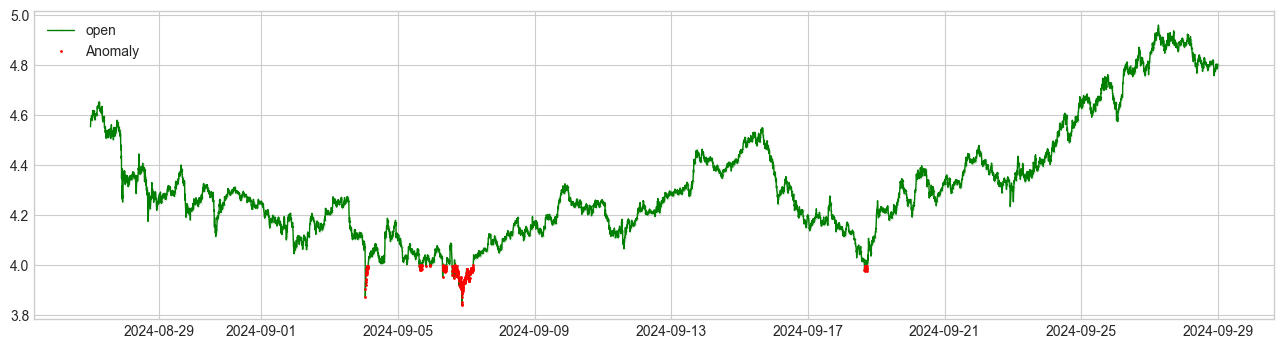

In [19]:
plot(s['open'], anomaly=anomalies, ts_linewidth=1, ts_markersize=0.1,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

2. Оценка по квантилям: сравнивает каждое значение временного ряда с историческими квантилями, например:  определяем моменты времени, когда температура превышает 99%-ный процентиль или ниже 1%-ного процентиля.


**Кванти́ль**  - значение, которое заданная случайная величина не превышает с фиксированной вероятностью. Если вероятность задана в процентах, то квантиль называется **процентилем** или **перцентилем**.


*   **0,25-квантиль** называется первым (или нижним) кварти́лем;

*   **0,5-квантиль** называется медианой;

*   **0,75-квантиль** называется третьим (или верхним) кварти́лем.

In [21]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)

In [22]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     9110
                            True       177
True   True   True   True   False      152
                     False  False        7
False  True   False  True   False        6
True   False  True   False  False        6
       True   False  True   False        5
       False  False  False  False        5
False  True   True   True   False        5
       False  True   True   True         5
True   True   True   True   True         5
False  True   False  False  False        4
       False  False  True   False        4
              True   False  True         3
True   True   False  False  False        3
       False  True   True   False        2
False  False  True   False  False        2
                     True   False        1
True   False  True   False  True         1
False  False  False  True   True         1
Name: count, dtype: int64

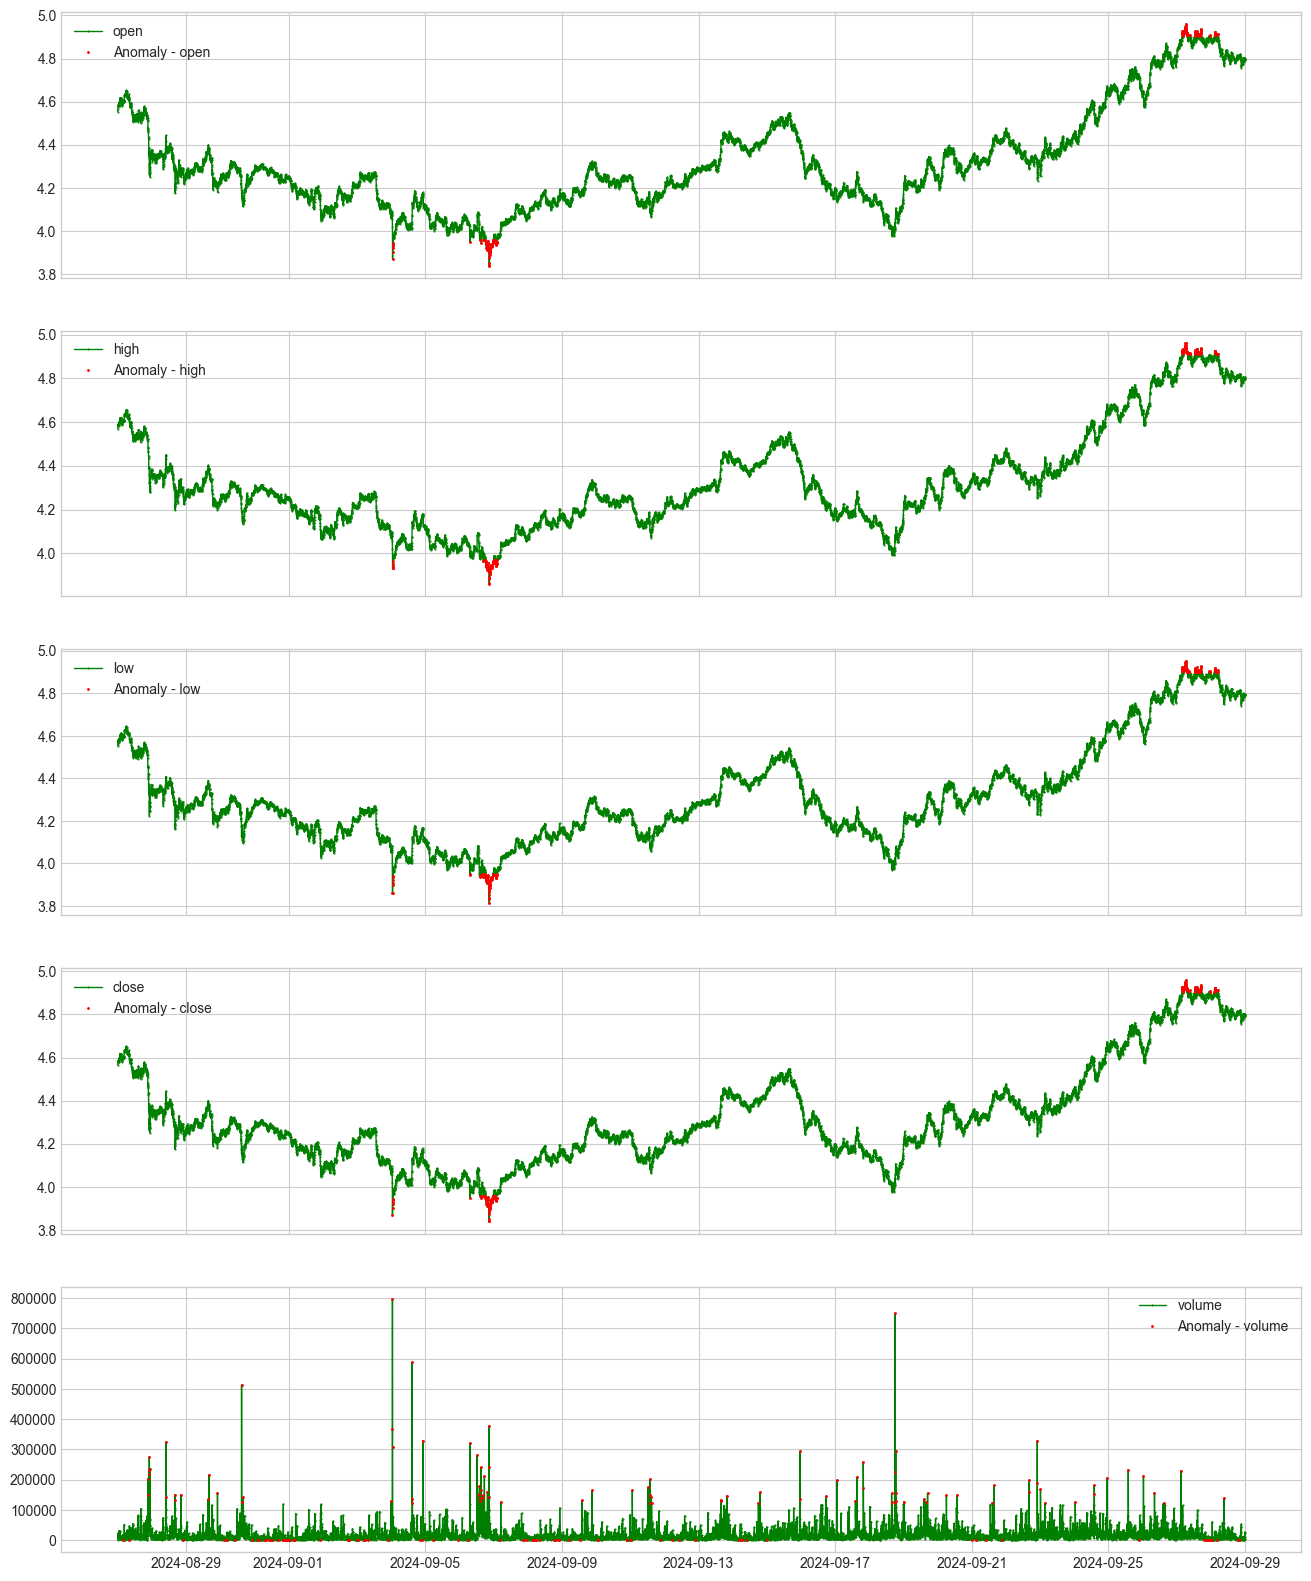

In [25]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

3. Межквартильный размах (InterQuartileRange - IQR)

## <center> Box Plot (ящик с усами)</center>

Границами ящика служат первый и третий квартили (25-й и 75-й пeрцентиль соответственно), линия в середине ящика — медиана (50-й процентиль). Концы усов — края статистически значимой выборки (без выбросов), и они могут определяться несколькими способами. Наиболее распространённые значения, определяющие длину «усов»:

*   Минимальное и максимальное наблюдаемые значения данных по выборке (в этом случае выбросы отсутствуют);
*   Разность первого квартиля и полутора межквартильных расстояний; сумма третьего квартиля и полутора межквартильных расстояний.

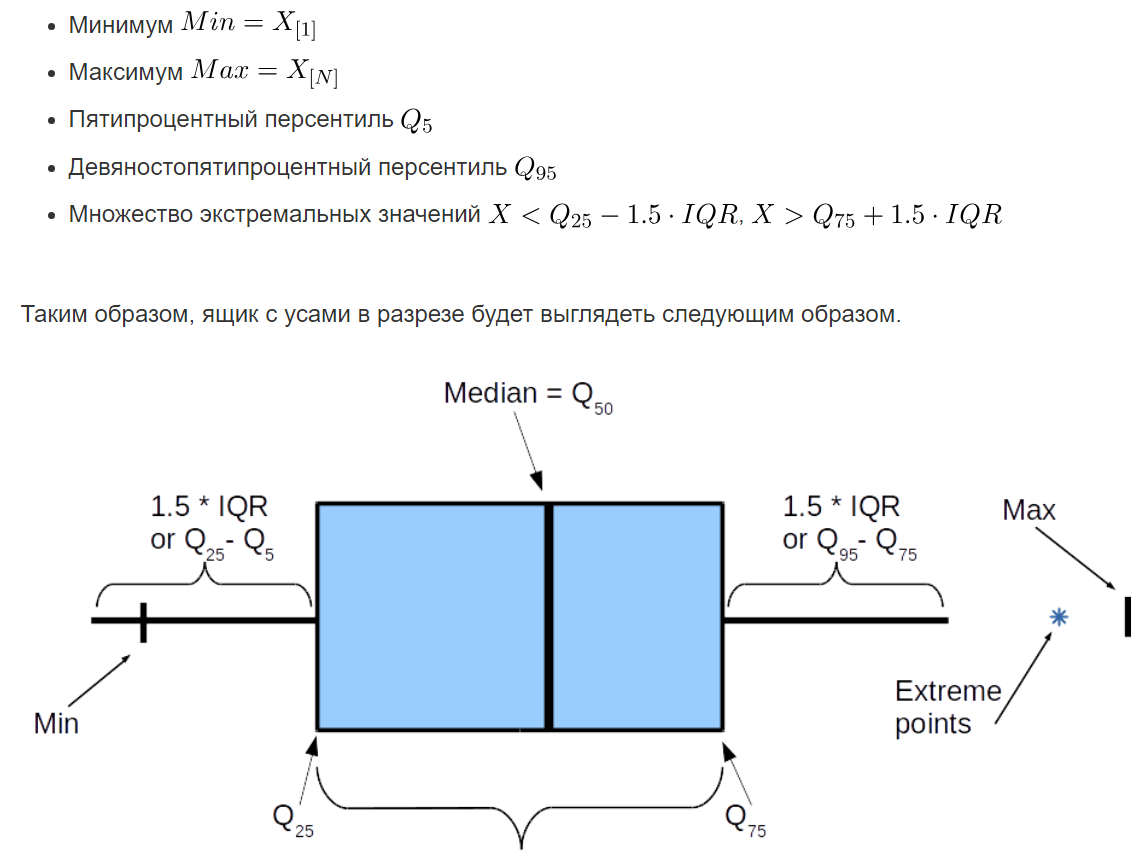

In [26]:
iqr_ad = InterQuartileRangeAD(c=1.5) # определяем ширину размаха в IQR
anomalies = iqr_ad.fit_detect(s)

In [27]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     8036
                            True       760
True   True   True   True   False      615
                            True        46
False  True   False  True   False       10
True   True   False  False  False        8
                     True   False        5
       False  False  False  False        4
False  True   False  False  False        4
              True   True   False        3
       False  False  True   False        3
       True   False  True   True         2
True   True   False  False  True         2
                     True   True         2
              True   False  False        2
       False  False  True   False        1
                     False  True         1
Name: count, dtype: int64

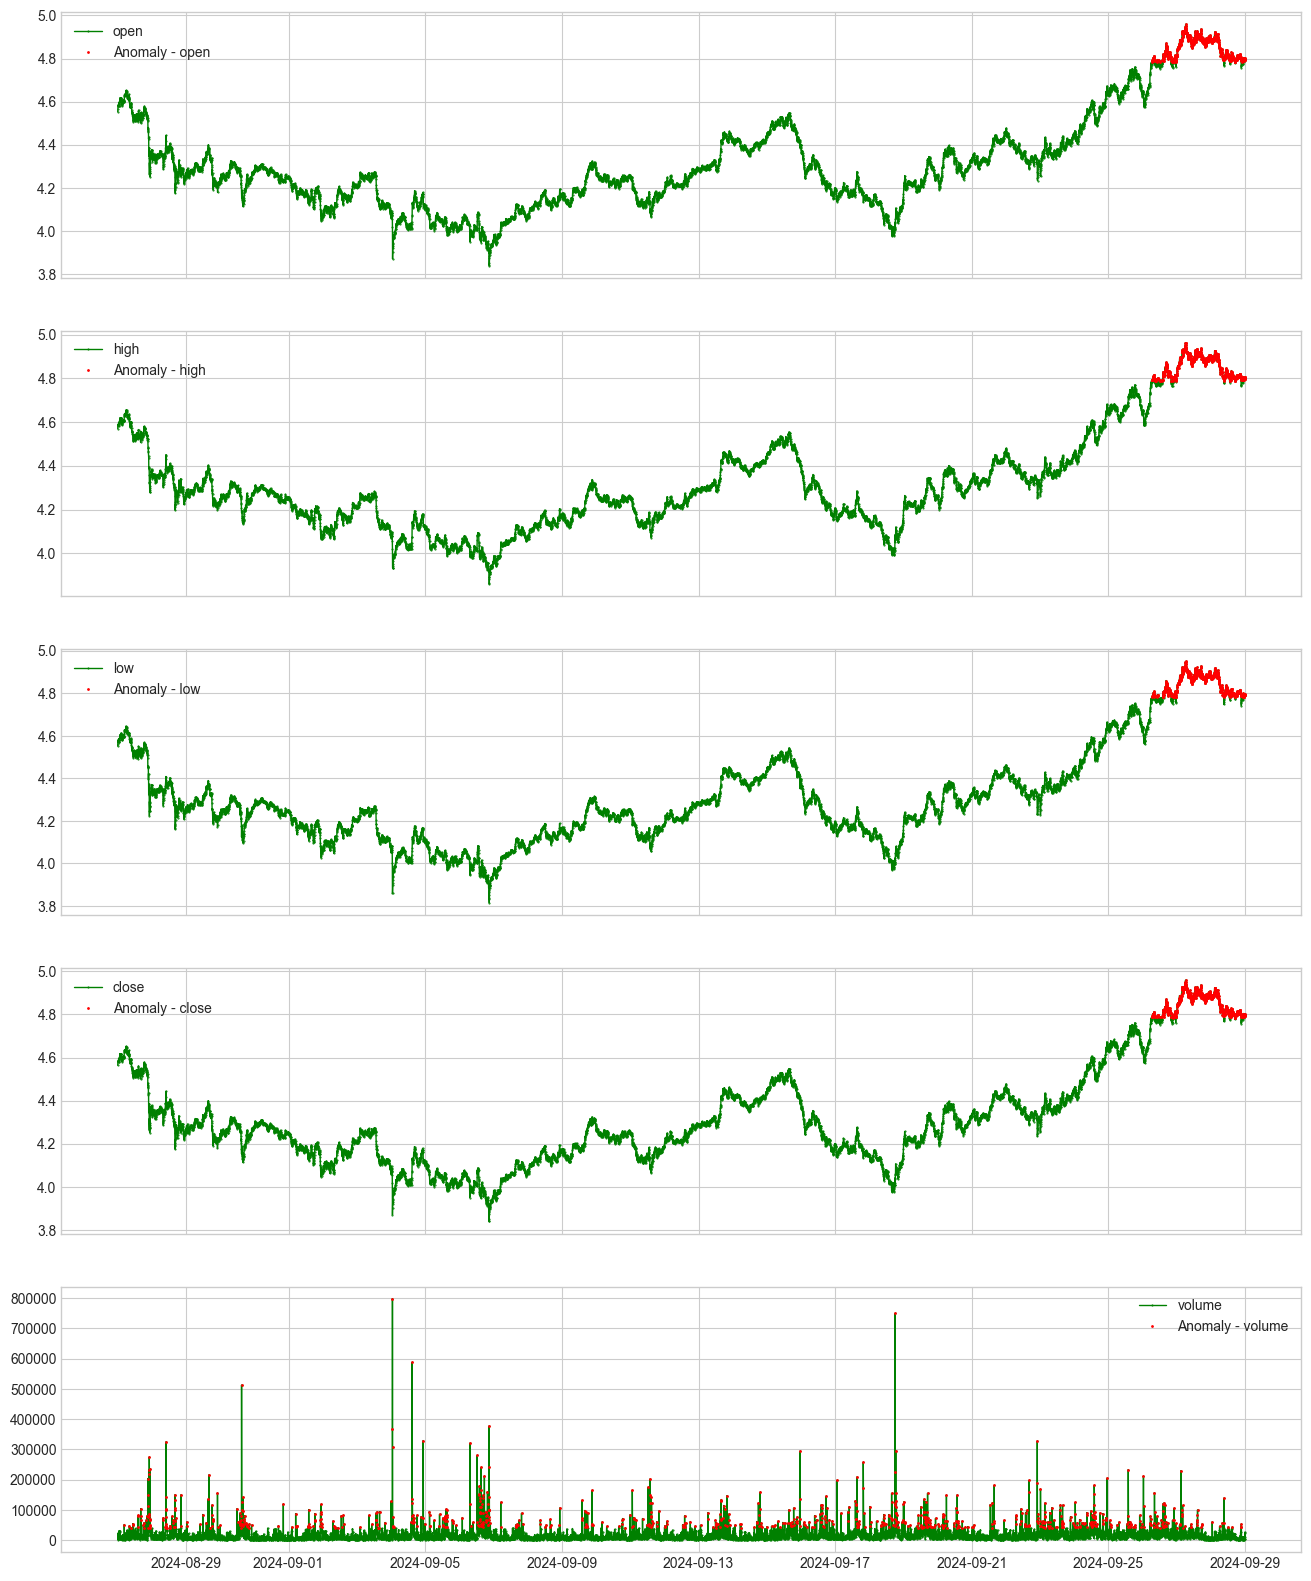

In [29]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

4. Обобщенный тест на экстремальное отклонение по Стьюденту (ESD)

ключевым допущением обобщенного теста ESD является то, что нормальные значения следуют приблизительно нормальному распределению.

In [30]:
esd_ad = GeneralizedESDTestAD(alpha=0.3) # указывается уровень значимости
anomalies = esd_ad.fit_detect(s)

In [31]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     9140
                            True       364
Name: count, dtype: int64

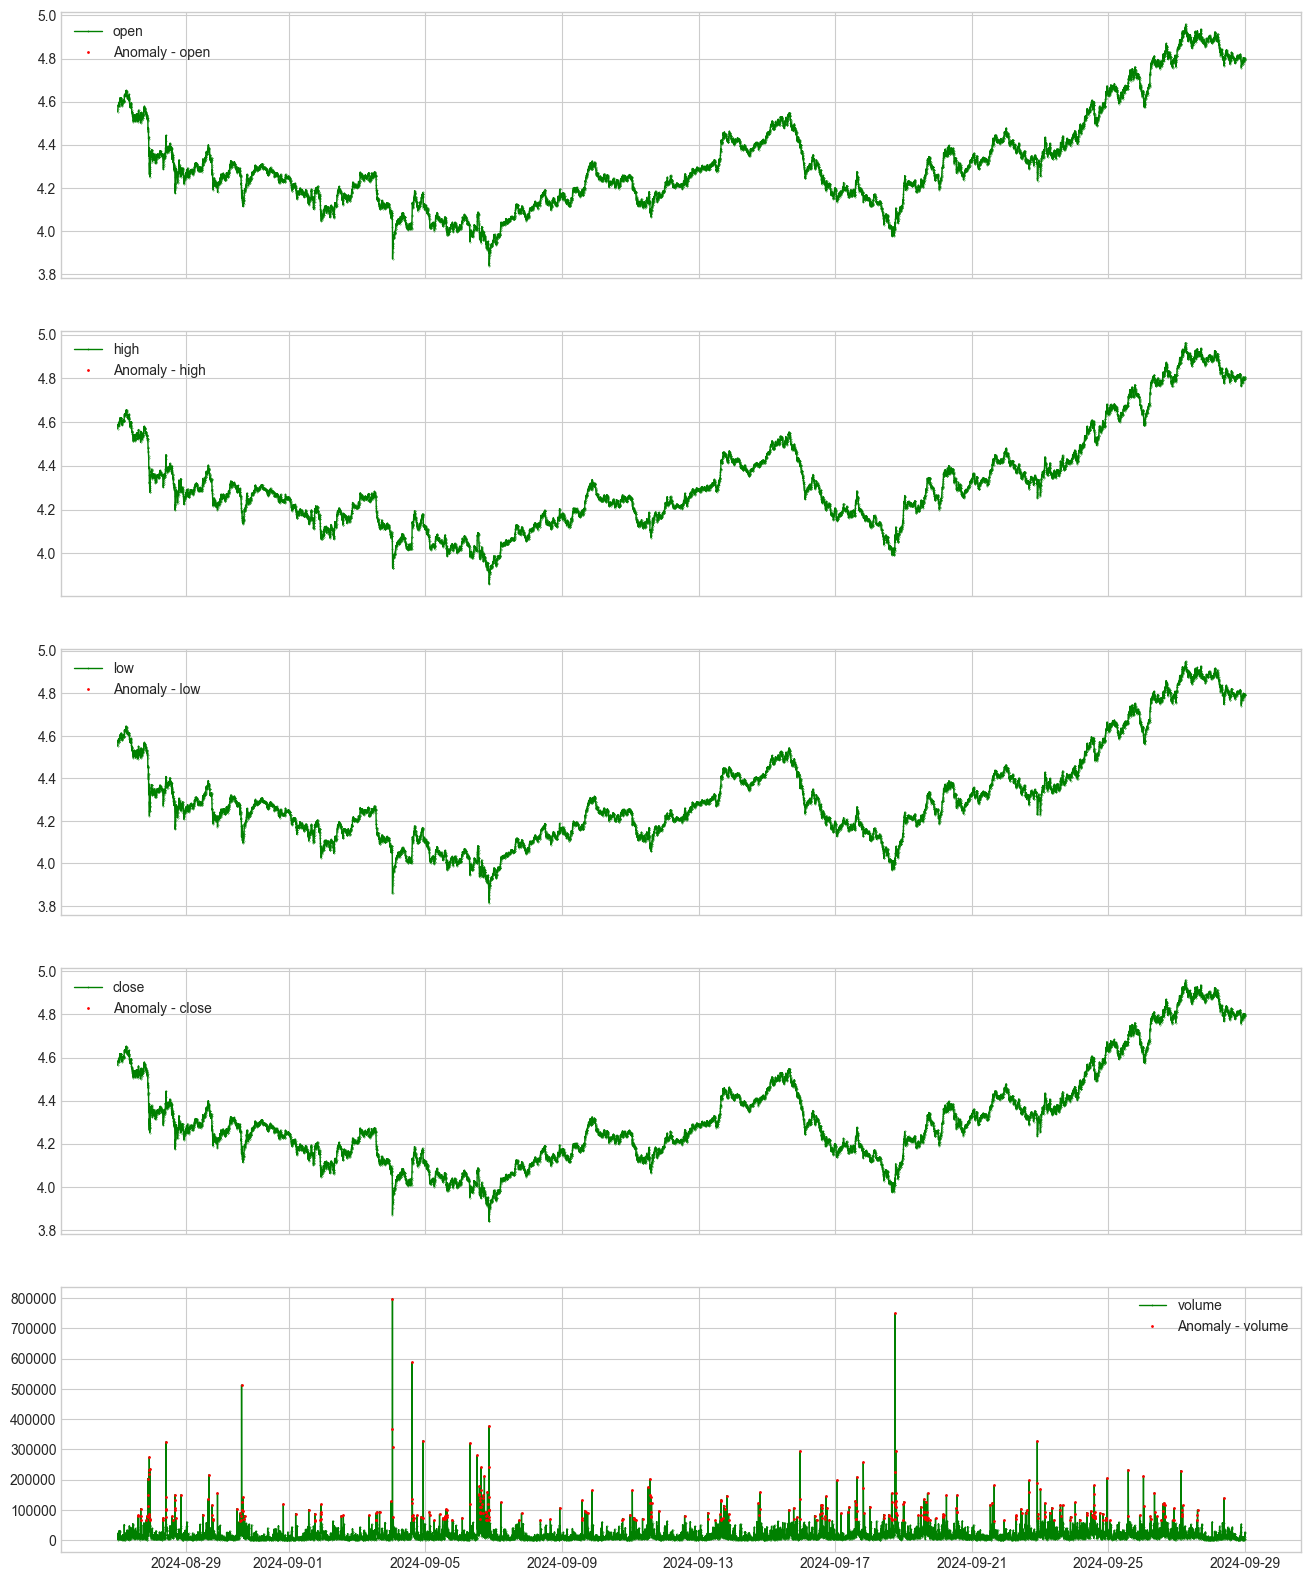

In [32]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=0.5,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

А как можно детектить групповые аномалии?

5.Персистентный метод (от слова Persist)
сравнивает каждое значение временного ряда с его предыдущими значениями. (онсован на процедуре двойного сглаживания с усредением DoubleRollingAggregate)

Пригоден для оценки поворотных точек и групповых аномалий

In [33]:
from adtk.detector import PersistAD
persist_ad = PersistAD(c=1.0, side='positive')
anomalies = persist_ad.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [34]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     8204
                            True       451
              True   False  False      128
True   False  True   False  False      125
              False  False  False      116
False  False  False  True   False      115
       True   False  False  False       81
                     True   False       74
                            True        48
                     False  True        34
              True   False  False       26
True   True   True   False  False       16
False  True   True   True   False       16
       False  False  True   True        11
True   True   True   True   False        8
                            True         7
False  True   True   True   True         6
True   False  False  False  True         6
False  False  True   True   False        5
                     False  True         5
True   False  True   False  True         5
       True   True   False  True         5
False  True   True 

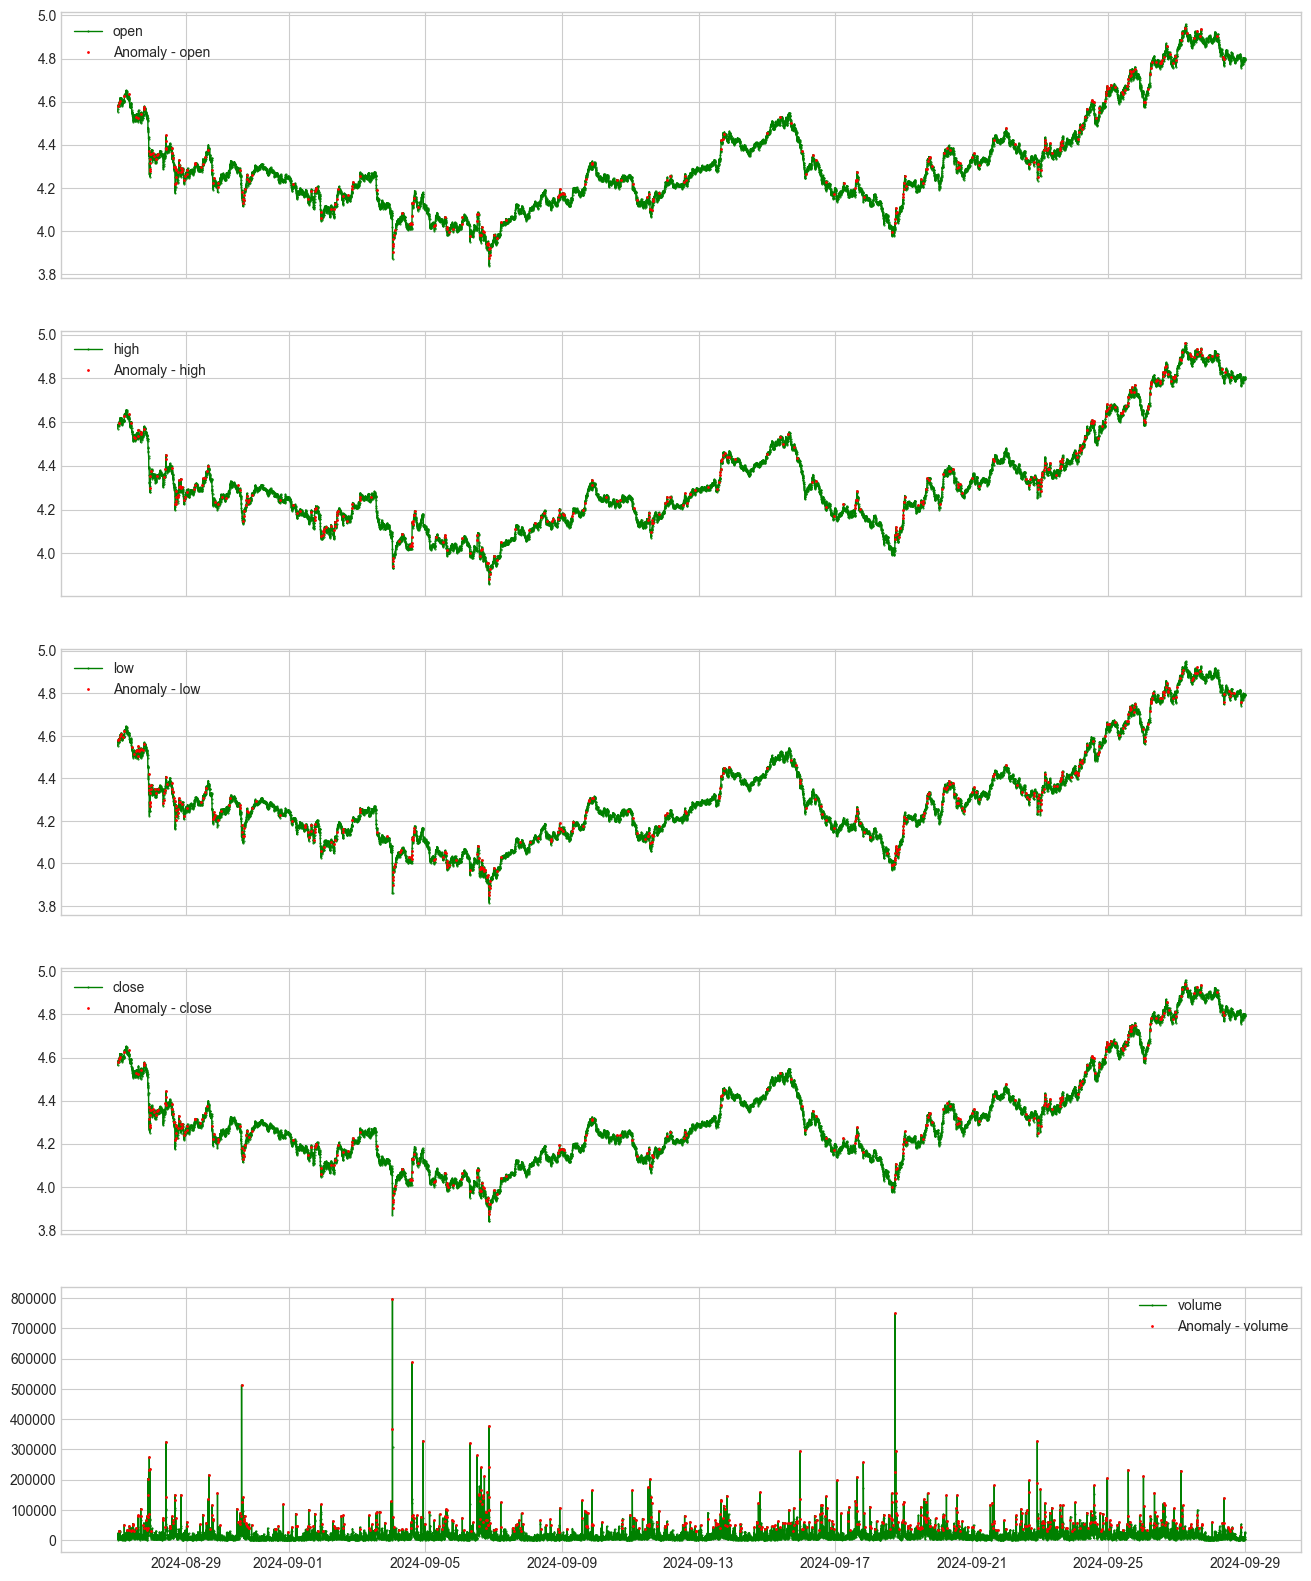

In [35]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

In [36]:
# s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/price_short.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

In [37]:
persist_ad = PersistAD(c=3.0, side='positive')
anomalies = persist_ad.fit_detect(s)
# plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [38]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     9177
                            True       201
              True   False  False       27
True   False  True   False  False       19
False  True   False  False  True        14
       False  False  True   False       13
       True   False  False  False       13
True   False  False  False  False       12
False  True   False  True   False       10
                            True         8
              True   False  False        3
True   False  True   True   False        2
False  False  True   False  True         1
                     True   False        1
True   False  False  False  True         1
       True   True   True   False        1
Name: count, dtype: int64

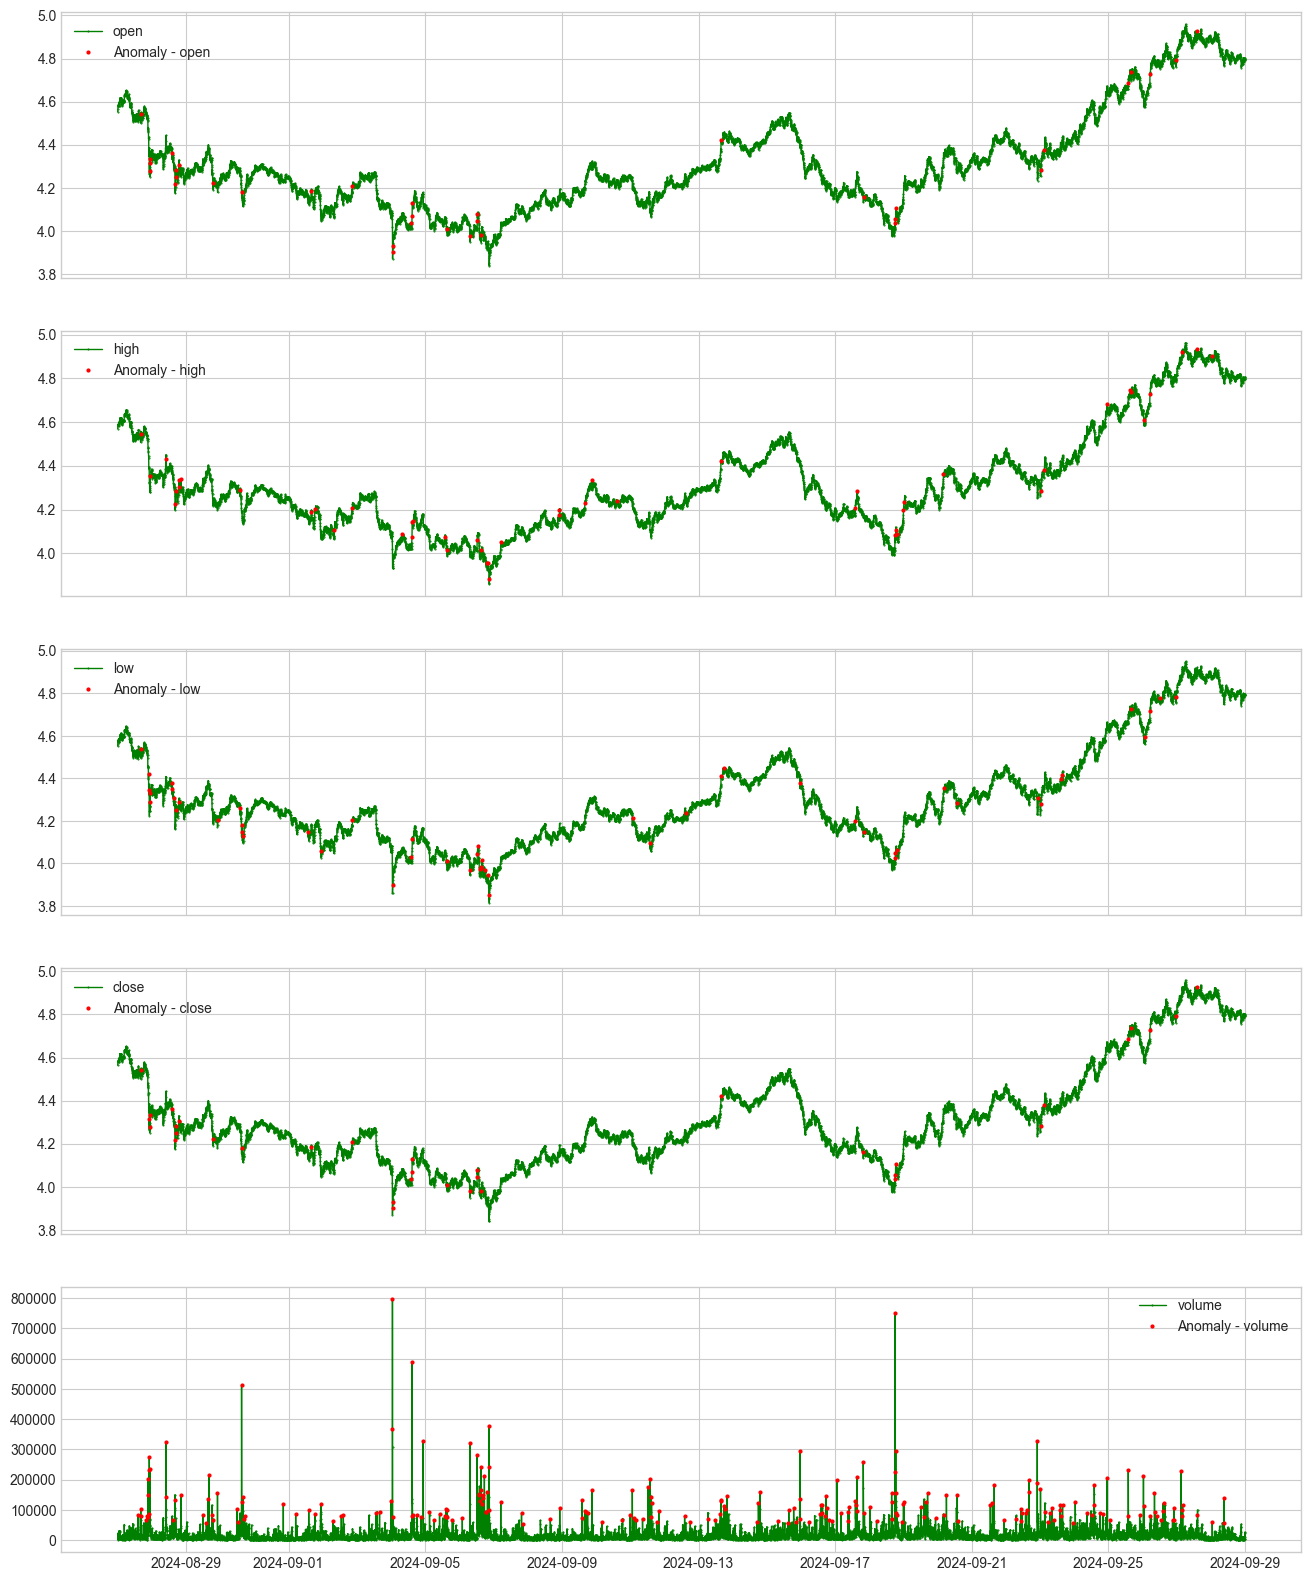

In [40]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=2, anomaly_color='red', anomaly_tag="marker", ts_color='g');

# anomaly_tag="span" - позволяет выделять область аномальных точек на графике, но не работает из-за обновлений (

По умолчанию PersistAD проверяется только одно предыдущее значение, которое хорошо улавливает аддитивную аномалию в краткосрочном масштабе, но не в долгосрочном. В следующем примере ему не удается зафиксировать значимое падение цены в более длительном масштабе времени.

In [41]:
# s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/price_long.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

In [42]:
persist_ad = PersistAD(c=1.5, side='negative')
anomalies = persist_ad.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [43]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     8637
                            True       371
              True   False  False      113
                     True   False       93
True   False  False  False  False       45
False  True   False  False  False       39
       False  False  True   False       38
True   True   False  False  False       35
       False  False  False  True        26
       True   False  False  True        24
              True   True   False       17
False  True   True   False  False       17
True   True   True   False  False       13
False  True   True   True   False       10
              False  False  True        10
       False  False  True   True         5
True   True   True   False  True         3
False  True   True   False  True         2
                     True   True         1
       False  True   True   True         1
True   False  True   False  False        1
                            True         1
False  False  True 

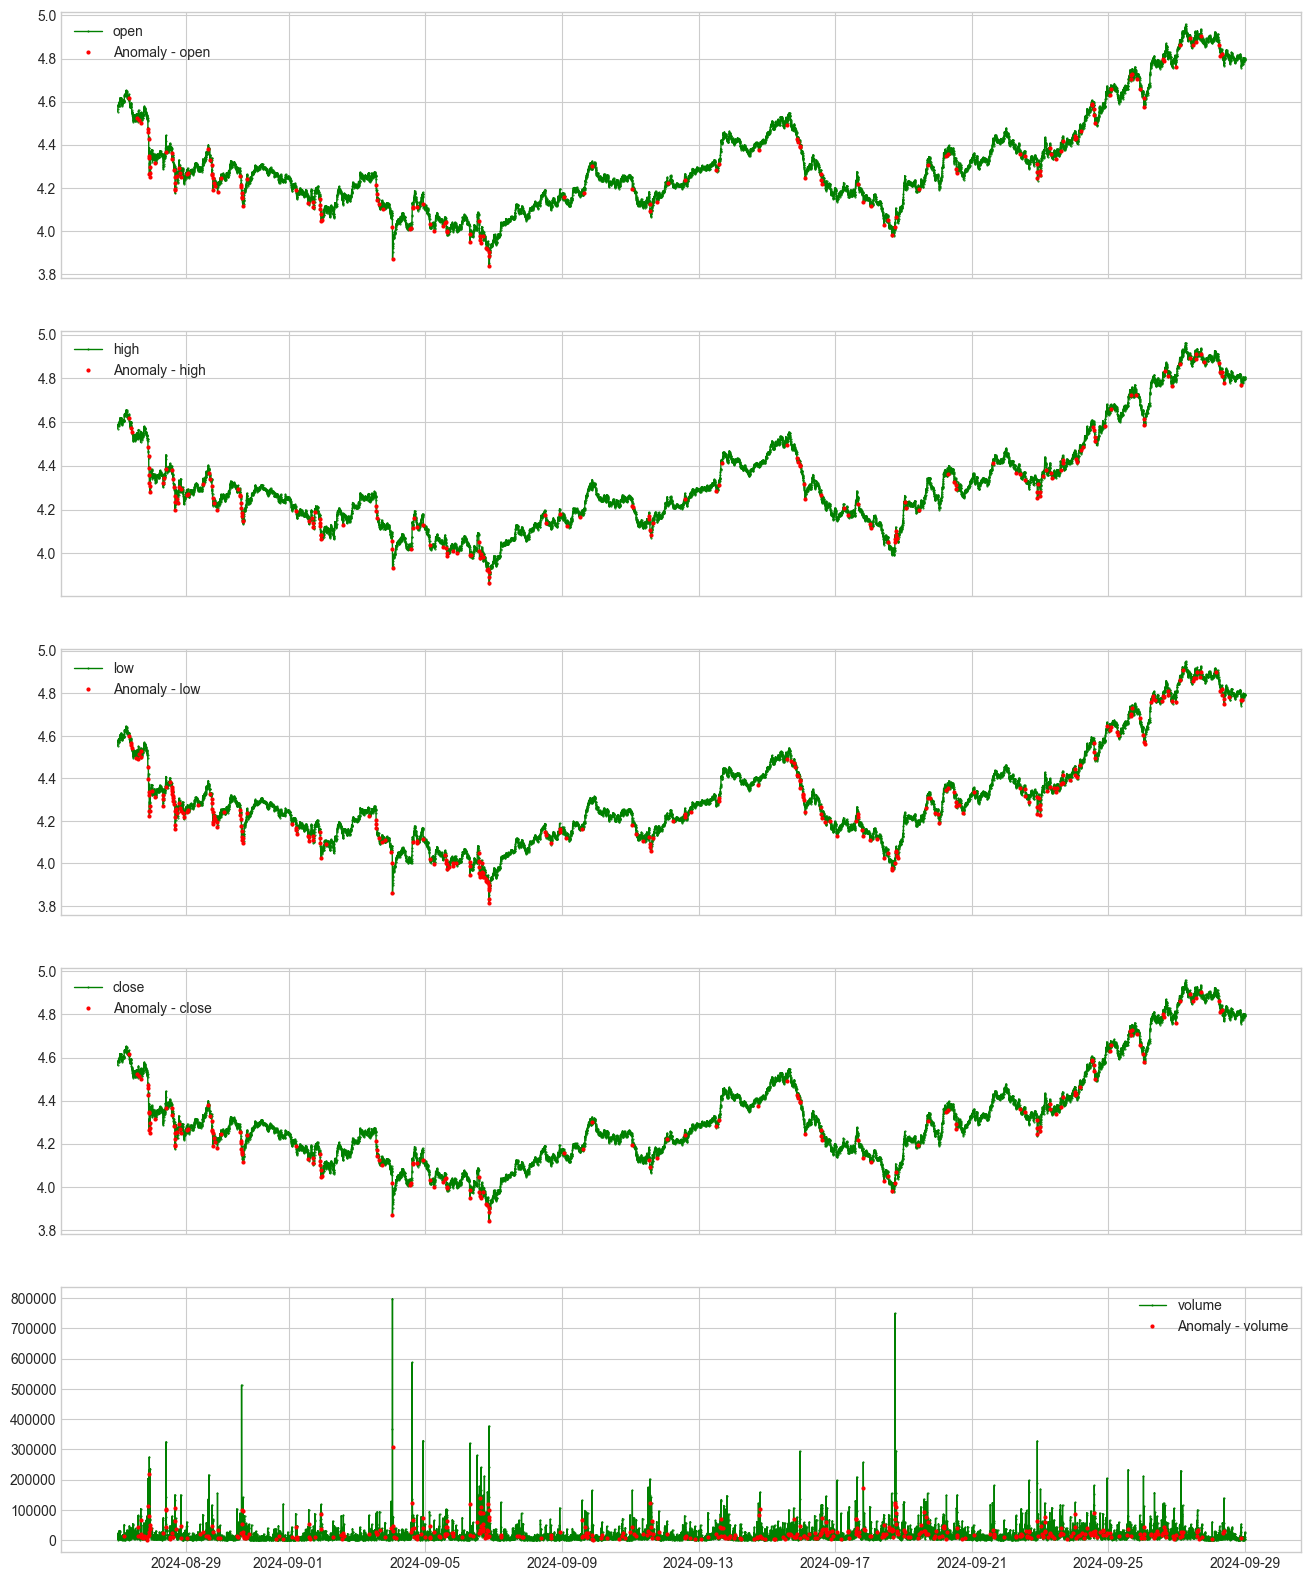

In [47]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=2, anomaly_color='red', anomaly_tag="marker", ts_color='g');

Мы можем изменить параметр window на число, большее 1, и детектор сравнит значение с медианой или средним значением предыдущего временного окна.

In [48]:
persist_ad.window = 30
anomalies = persist_ad.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [49]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     9116
True   True   True   True   False      163
False  False  False  False  True        64
              True   True   False       28
                     False  False       23
True   False  False  False  False       19
              True   False  False       12
       True   True   False  False       12
False  False  False  True   False       10
       True   True   True   False        8
True   True   False  True   False        6
False  True   False  True   False        3
True   True   False  False  False        3
              True   False  True         1
       False  False  True   False        1
       True   False  False  True         1
       False  True   True   False        1
              False  False  True         1
False  True   False  False  False        1
True   True   True   True   True         1
Name: count, dtype: int64

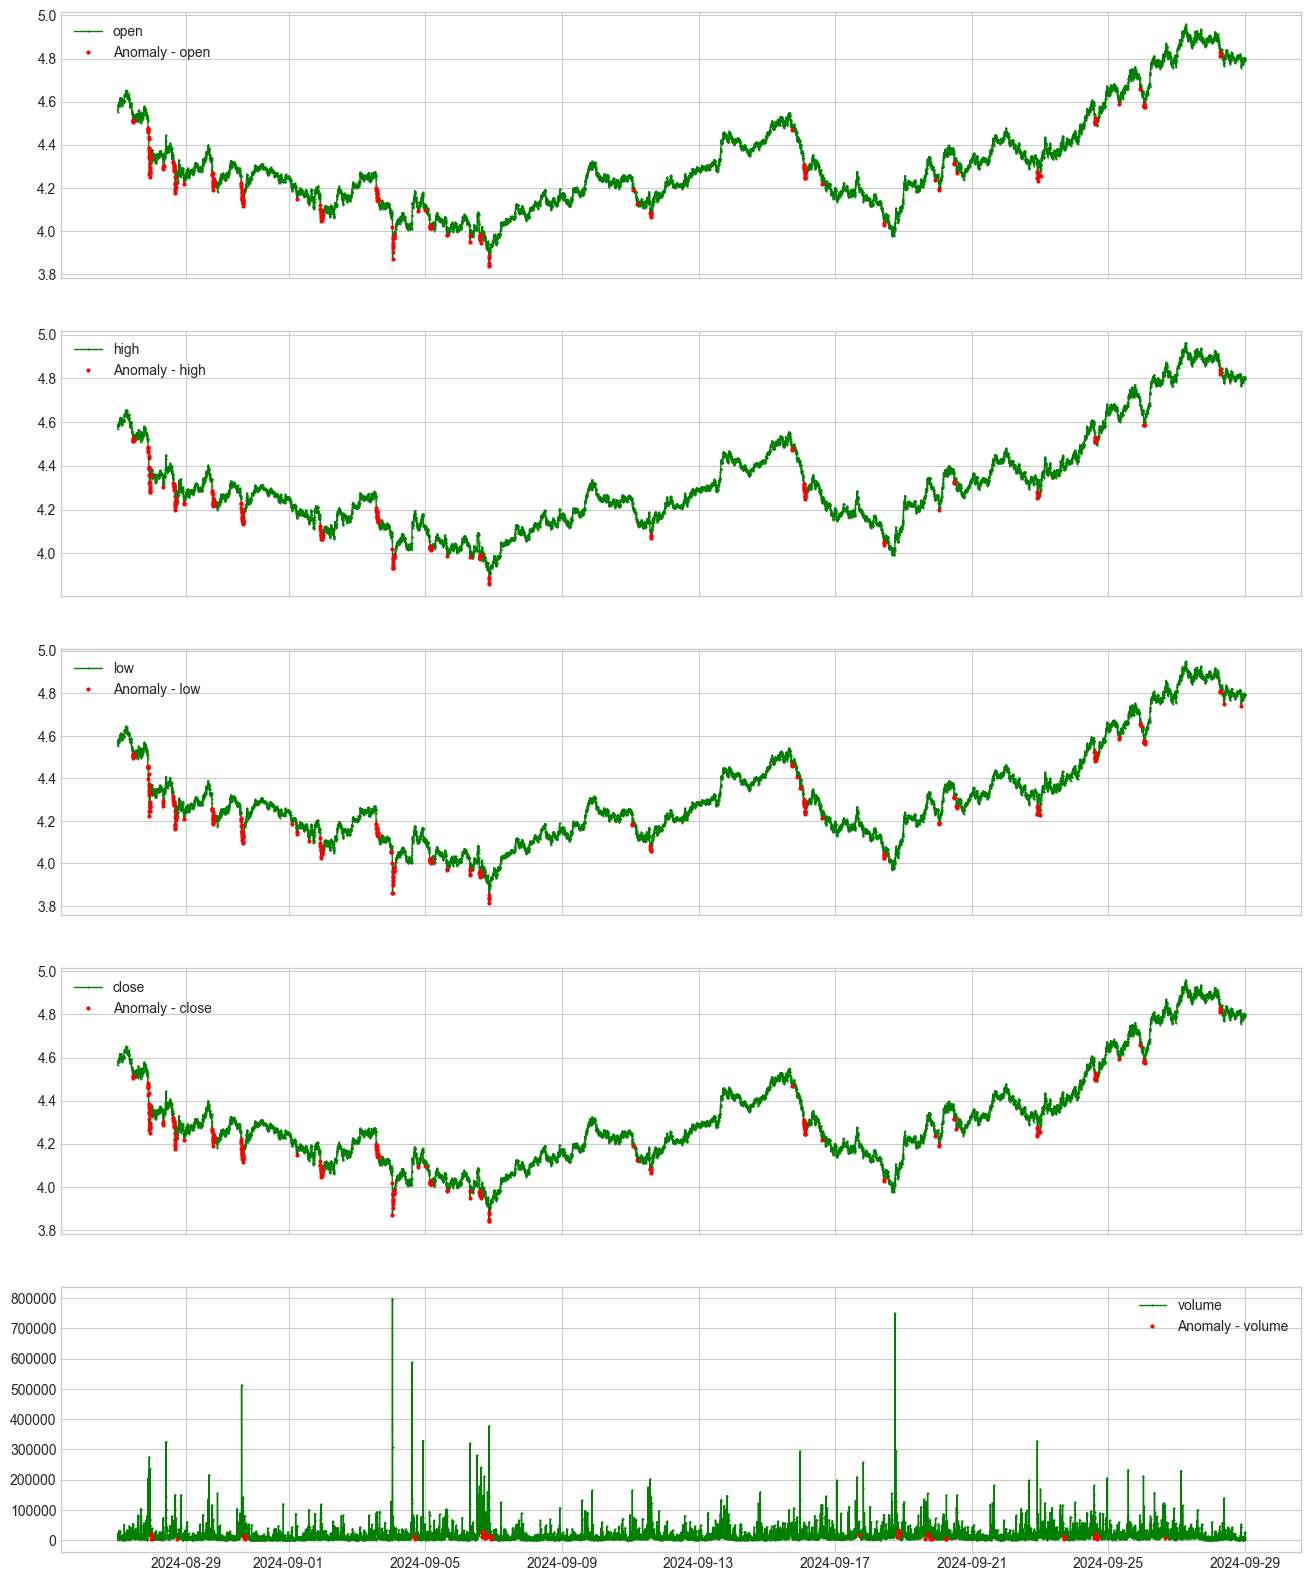

In [50]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=2, anomaly_color='red', anomaly_tag="marker", ts_color='g');

6. Level shift - судя по названию детектит сдвиги по уровню, при этом отслеживая разницу между средними значениями в двух скользящих временных окнах, расположенных рядом друг с другом.

In [ ]:
# s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/cpu.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

In [51]:
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [52]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     9373
                            True        98
True   True   True   True   False        4
              False  False  False        3
              True   True   True         3
False  False  True   True   False        2
       True   True   True   True         2
       False  True   True   True         1
       True   False  True   True         1
       False  True   False  True         1
True   False  False  False  False        1
              True   True   False        1
False  False  True   False  False        1
True   True   False  False  True         1
              True   False  False        1
                            True         1
False  False  False  True   False        1
Name: count, dtype: int64

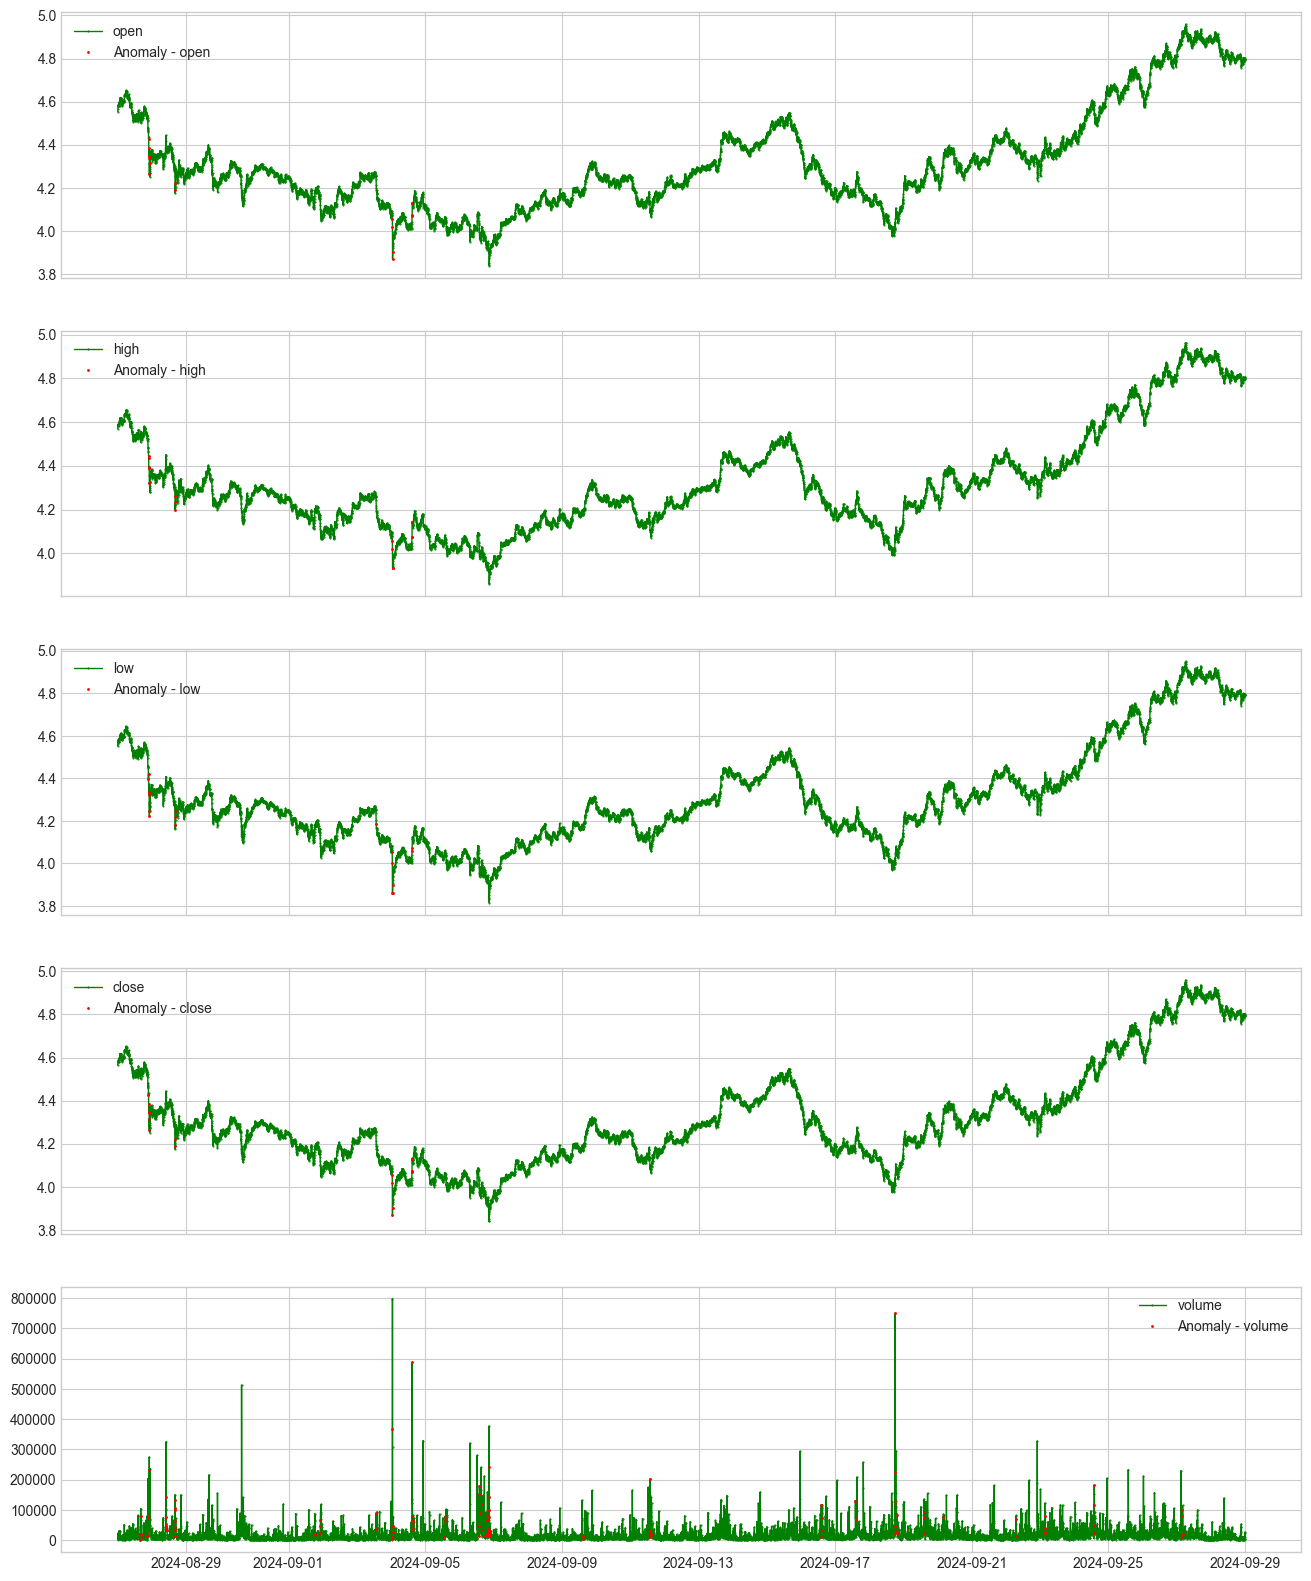

In [54]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

7. VolatilityShift - обнаруживает сдвиг уровня волатильности, отслеживая разницу между стандартными отклонениями в двух скользящих временных окнах, расположенных рядом друг с другом.

In [58]:
s,_ = load_train_test('DOTUSDT')
s = validate_series(s)

In [59]:
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [60]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     9031
                            True       225
True   True   True   True   False       94
                            True        38
       False  True   True   False        8
False  True   False  False  False        7
True   True   False  True   False        6
False  False  True   False  False        5
True   False  False  False  False        5
False  False  True   True   False        4
True   False  True   False  False        3
False  True   True   True   False        2
True   False  True   False  True         2
False  True   False  True   False        2
True   False  True   True   True         2
False  False  False  True   False        2
       True   True   False  False        1
              False  True   True         1
       False  True   True   True         1
True   True   False  False  False        1
                            True         1
False  True   False  False  True         1
True   True   False

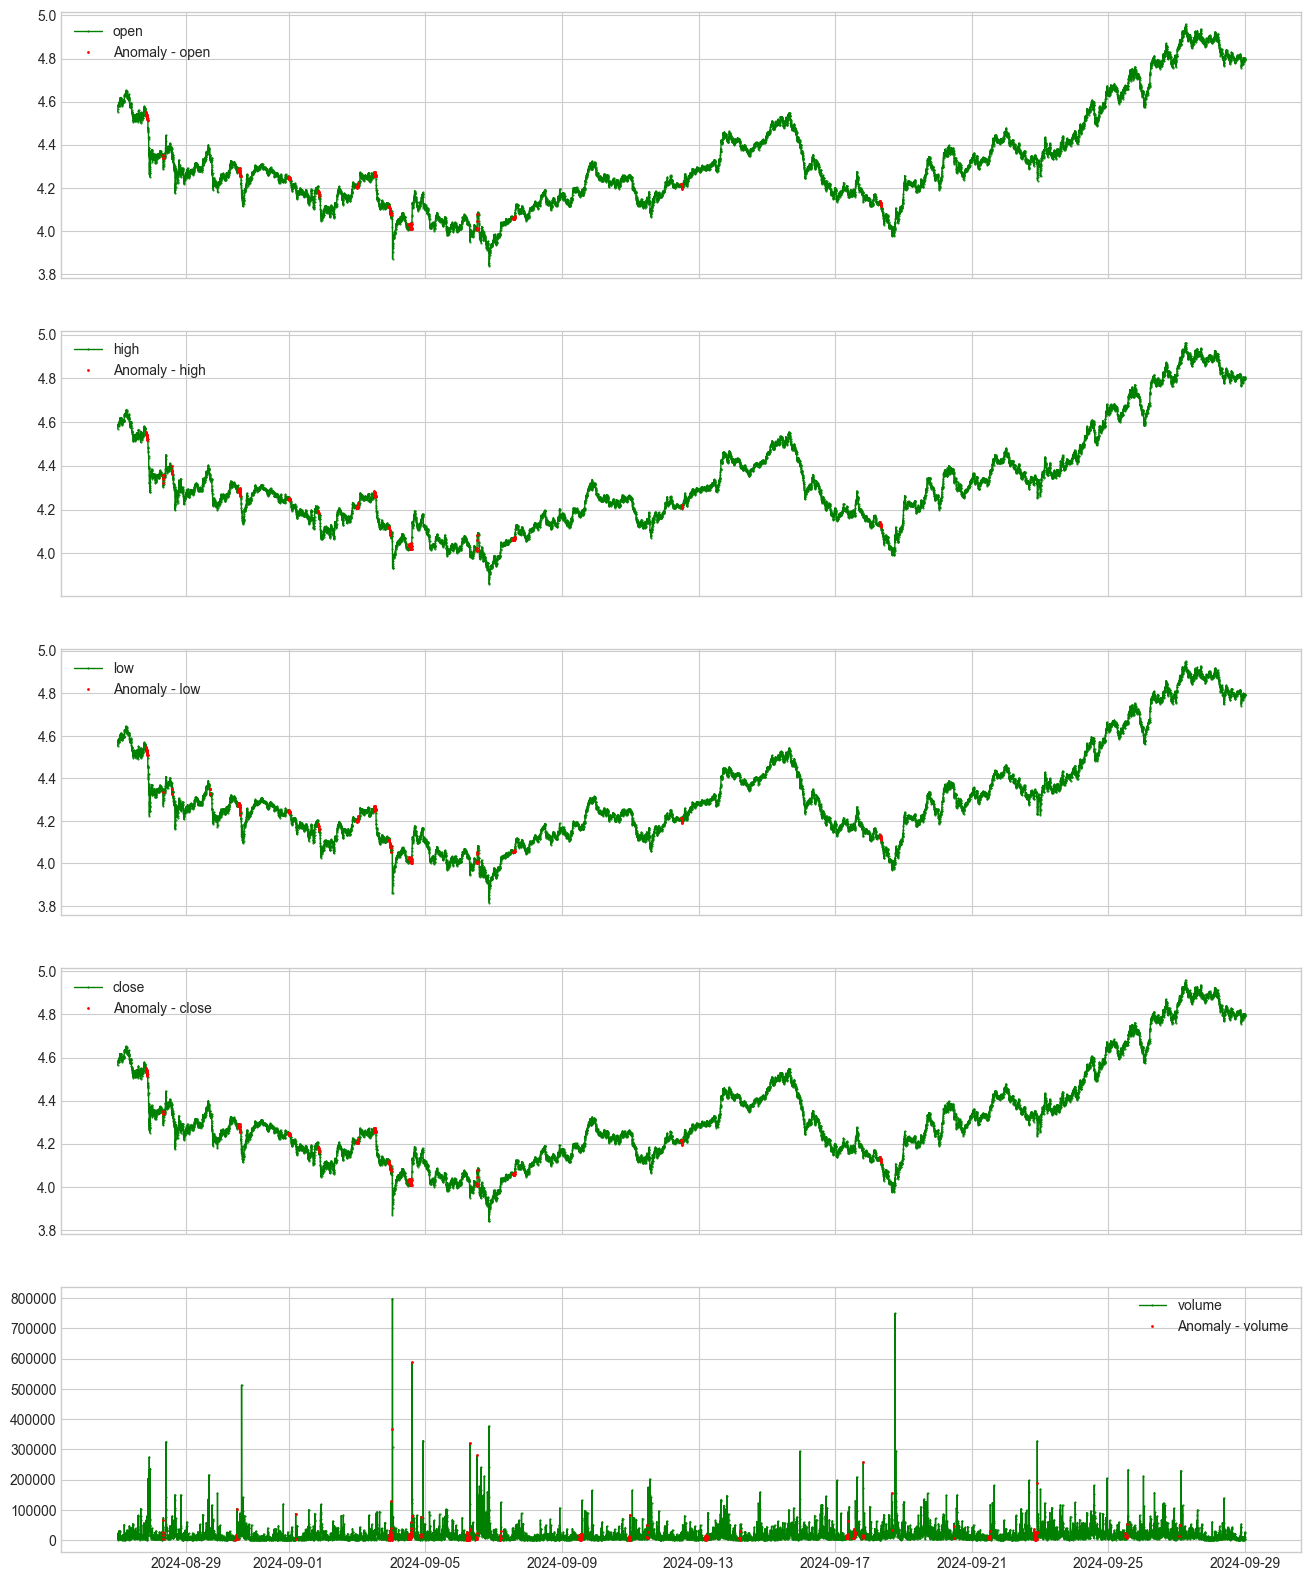

In [61]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=1,
     anomaly_markersize=1, anomaly_color='red', anomaly_tag="marker", ts_color='g');

8. Детекция на основе сезонности - обнаруживает аномальные нарушения сезонной структуры.

алгоритм декомпозирует ряд на трендовую часть (необязательно), сезонную часть и остаточную часть. Остаточная часть может помочь выявить аномальное отклонение от сезонной модели.

In [62]:
s,_ = load_train_test('DOTUSDT')
s = validate_series(s)

In [63]:
seasonal_ad = SeasonalAD(c=3.0, side="both")
anomalies = seasonal_ad.fit_detect(s)

Exception: Could not find significant seasonality.

In [ ]:
anomalies.value_counts()

Traffic
False    10048
True       272
Name: count, dtype: int64

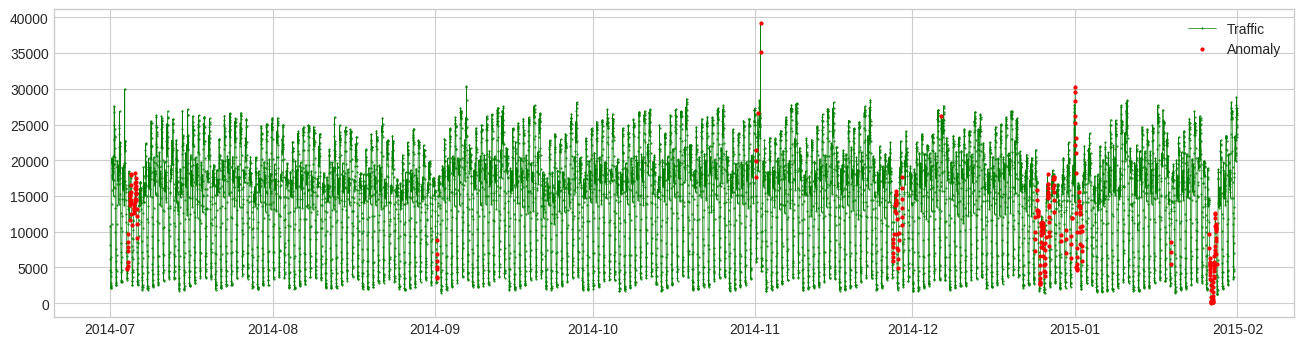

In [ ]:
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2, ts_color='g');

9. Авторегрессионные модели - обнаруживает аномальные изменения поведения авторегрессии во временных рядах: выполняет регрессию к многомерному ряду и возвращает регрессивный остаток. Это может помочь выявить аномальное нарушение обычной взаимосвязи между рядами.

In [64]:
autoregression_ad = AutoregressionAD(n_steps=7*2, step_size=24, c=3.0)
anomalies = autoregression_ad.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [65]:
anomalies.value_counts()

open   high   low    close  volume
False  False  False  False  False     8646
                            True       443
True   True   True   True   False       24
                            True         9
False  False  True   True   False        6
True   False  False  False  False        5
False  False  True   True   True         4
True   False  True   False  False        4
False  False  True   False  False        3
              False  True   False        3
True   False  True   False  True         3
False  True   True   True   True         2
True   True   True   False  False        2
False  False  True   False  True         2
True   True   False  False  False        1
              True   False  True         1
              False  True   False        1
                     False  True         1
False  True   False  False  False        1
True   False  True   True   True         1
False  True   False  False  True         1
True   False  False  False  True         1
False  False  False

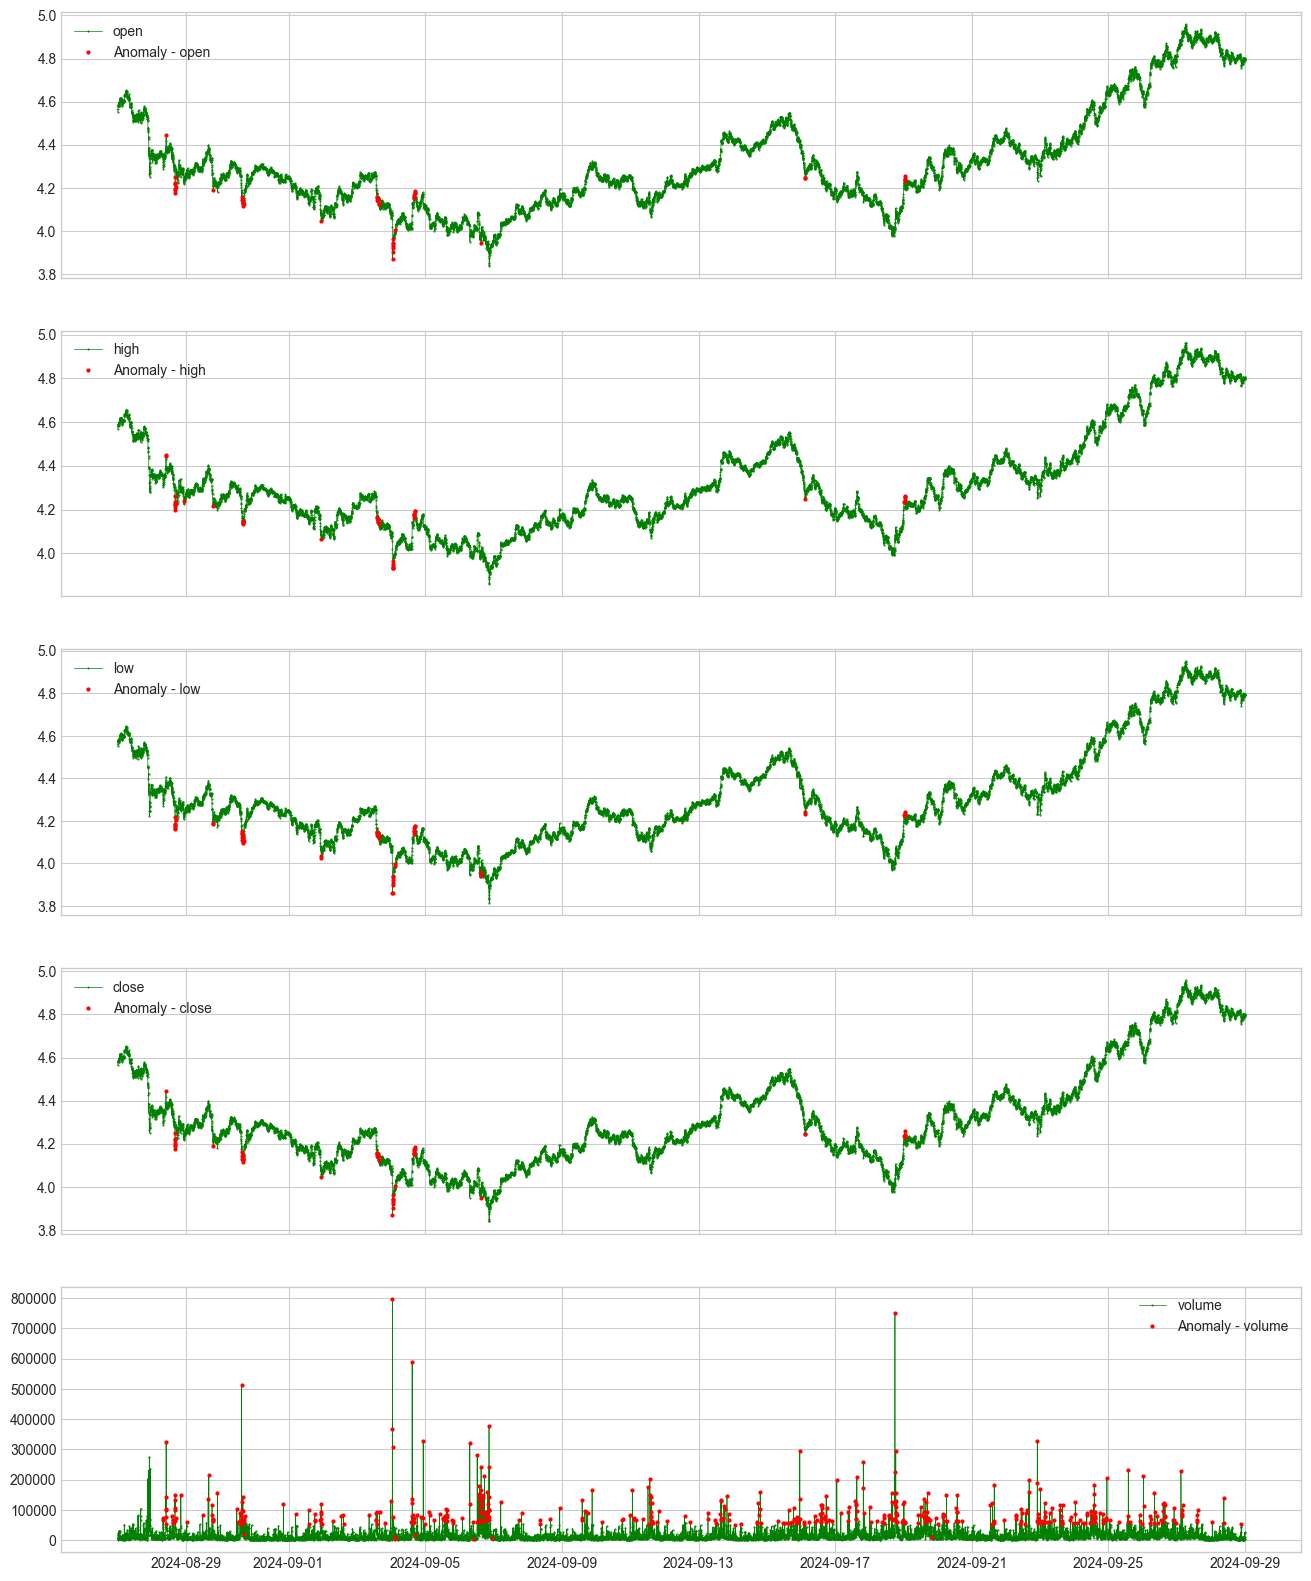

In [66]:
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2,  ts_color='g');

10. MinClusterDetector - рассматривает многомерные временные ряды как независимые точки в многомерном пространстве, делит их на кластеры и идентифицирует значения в наименьшем кластере как аномальные.

In [ ]:
df = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/generator.csv', index_col="Time", parse_dates=True).squeeze('columns')
df = validate_series(df)

In [67]:
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(s)


In [68]:
anomalies.value_counts()

False    9470
True       34
Name: count, dtype: int64

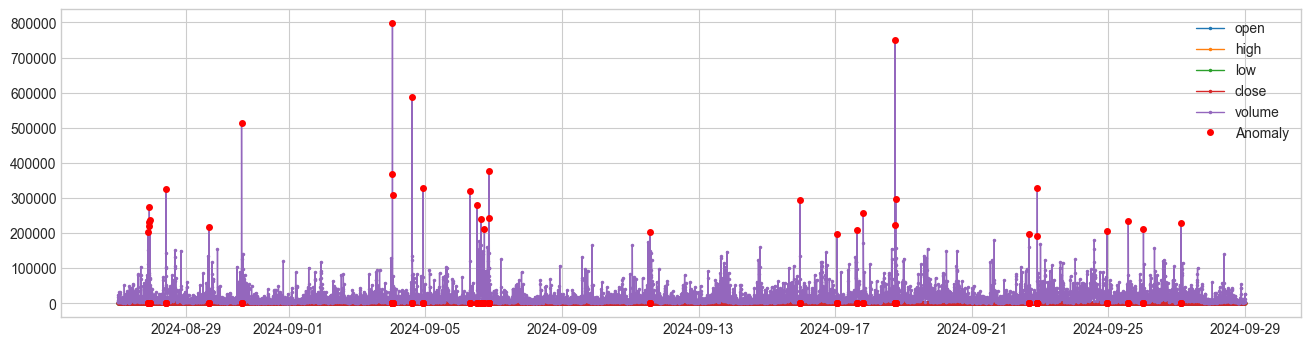

In [70]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all', anomaly_tag="marker");

11. OutlierDetector - выполняет многомерное обнаружение выбросов, не зависящее от времени, и идентифицирует выбросы как аномалии. Многомерным алгоритмом обнаружения выбросов может быть алгоритм scikit-learn или других пакетов, использующих тот же API.

Например, LocalOutlierFactor Он измеряет локальное отклонение плотности данной выборки по отношению к ее соседям. Он является локальным в том смысле, что оценка аномалии зависит от того, насколько изолирован объект относительно окружающих окрестностей.

In [ ]:
# from adtk.detector import OutlierDetector
# from sklearn.neighbors import LocalOutlierFactor

In [71]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(s)

/home/admin1/проекты/OTUS/Fin_RL/fin_proj/finRL/lib/python3.12/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False  True False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  is_outliers.loc[df.dropna().index] = (


In [72]:
anomalies.value_counts()

False    9028
True      476
Name: count, dtype: int64

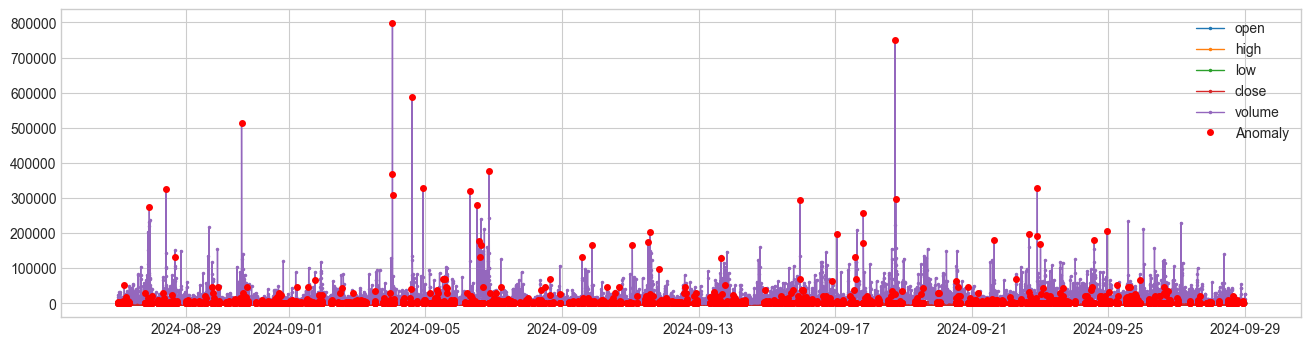

In [73]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all',anomaly_tag="marker");

12. Регрессия - обнаруживает аномальное нарушение обычной взаимосвязи между многомерными рядами путем отслеживания ошибки.

In [ ]:
# from adtk.detector import RegressionAD
# from sklearn.linear_model import LinearRegression

In [ ]:
anomalies.value_counts()

False    380
True      20
Name: count, dtype: int64

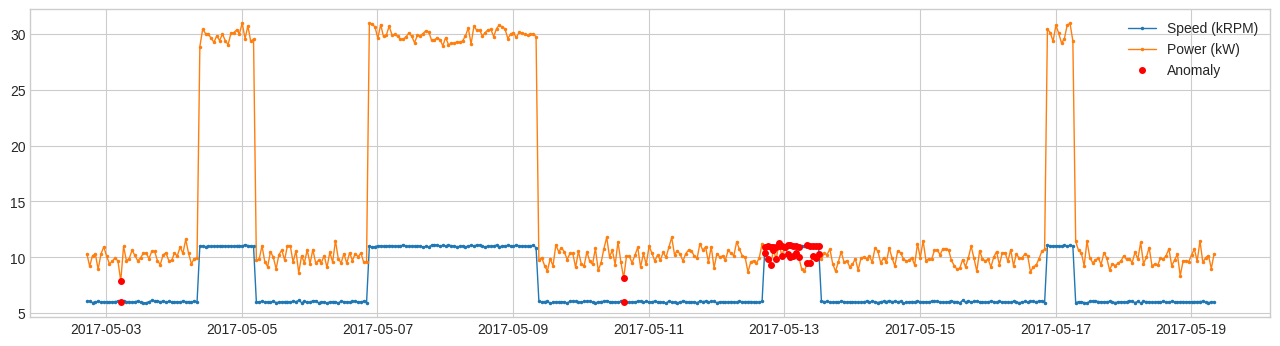

In [ ]:
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all', anomaly_tag="marker");

13. Методы уменьшения размерности - например, PCA выполняет анализ главных компонент для многомерных временных рядов (каждая временная точка в виде вектора в многомерном пространстве) и отслеживает ошибку восстановления этих векторов.

In [ ]:
# from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(df)


In [ ]:
anomalies.value_counts()

False    380
True      20
Name: count, dtype: int64

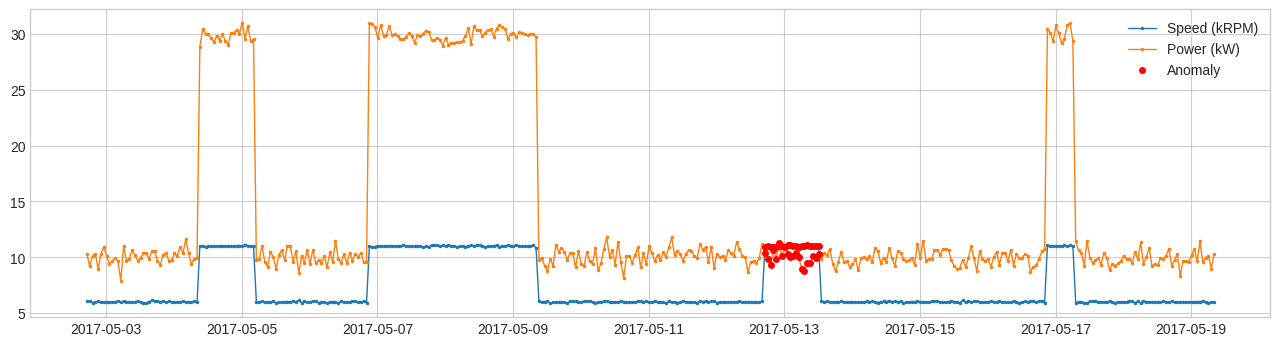

In [ ]:
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all', anomaly_tag="marker");

14. CustomizedDetector
помогают пользователю преобразовать функцию в настраиваемый объект detector, который может использоваться (например, объектом Pipeline )

In [ ]:
df = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)
df.head()

Speed (kRPM)  Power (kW)
Time                                         
2017-05-02 17:08:37      6.066579   10.308257
2017-05-02 18:08:37      6.035764    9.186763
2017-05-02 19:08:37      5.922730   10.128382
2017-05-02 20:08:37      5.999581   10.290300
2017-05-02 21:08:37      6.031067    8.910037

In [ ]:
# Пишем собственную функцию для определения возаимосвязи нормального поведения системы в зависимости от факторов
def myDetectionFunc(df):
    return (df["Speed (kRPM)"] * 1.2 > df["Power (kW)"])

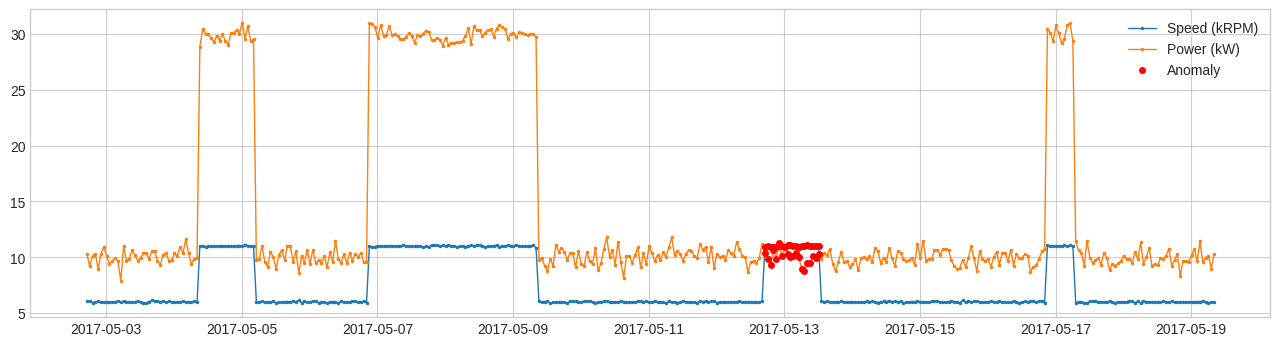

In [ ]:
# from adtk.detector import CustomizedDetectorHD
customized_detector = CustomizedDetectorHD(detect_func=myDetectionFunc)
anomalies = customized_detector.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all', anomaly_tag="marker");

## А что под капотом????

1. Скользящее среднее - RollingAggregate


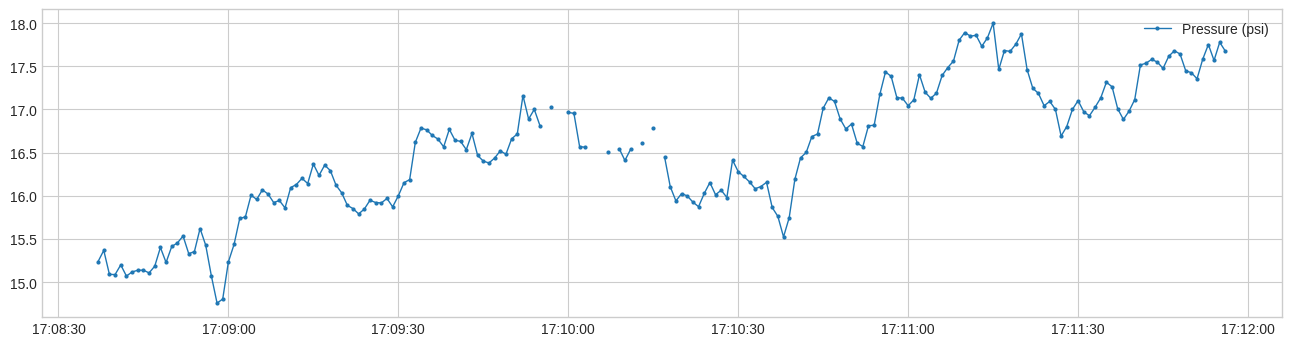

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/pressure.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)
plot(s, ts_linewidth=1, ts_markersize=4);

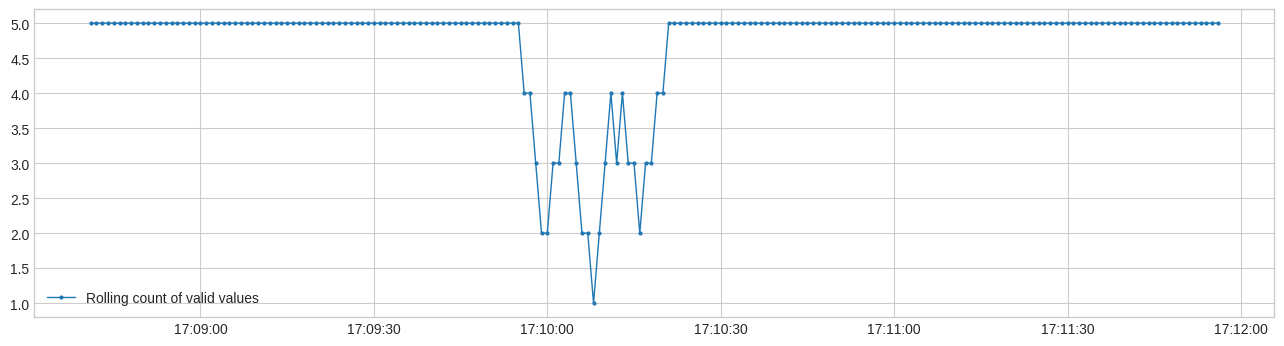

In [ ]:
from adtk.transformer import RollingAggregate
s_transformed = RollingAggregate(agg='count', window=5).transform(s)
plot(s_transformed.rename("Rolling count of valid values"), ts_linewidth=1, ts_markersize=4);

2. Двойное скользящее среднее - DoubleRollingAggregate

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/seismic.csv', index_col="Time", parse_dates=True).squeeze('columns')
s=validate_series(s)

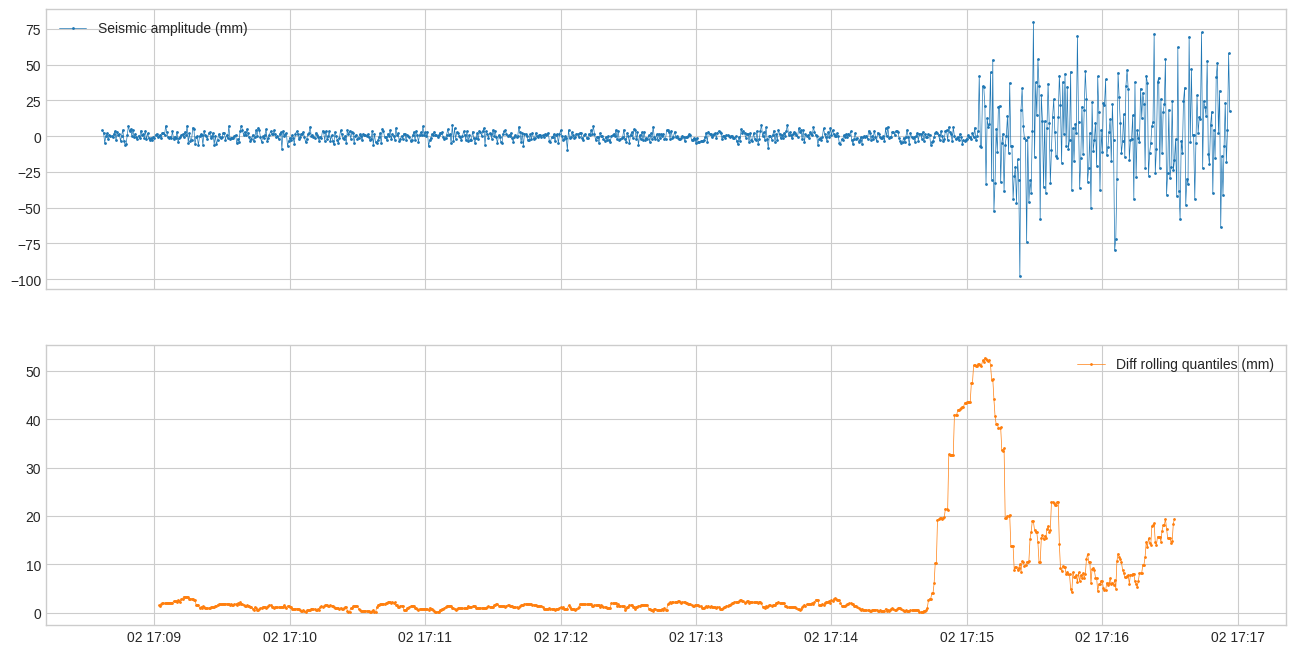

In [ ]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="quantile",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=50,
    diff="l2").transform(s).rename("Diff rolling quantiles (mm)")

plot(pd.concat([s, s_transformed], axis=1));

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/cpu.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

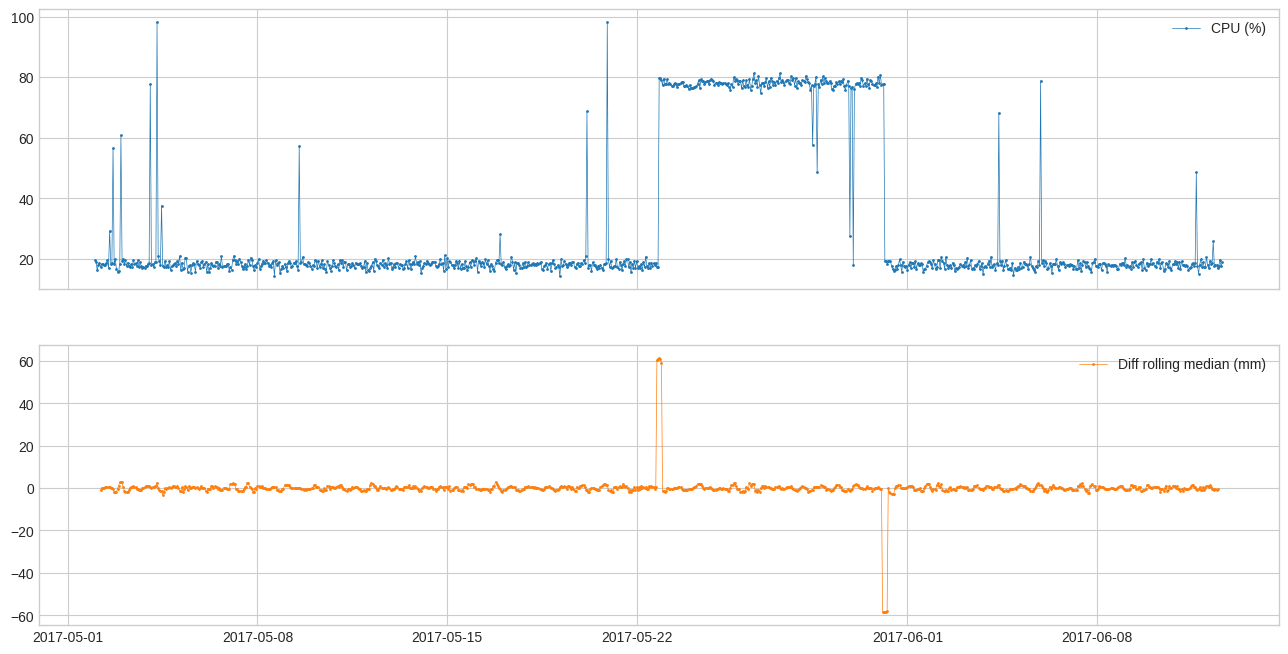

In [ ]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="median",
    window=5,
    diff="diff").transform(s).rename("Diff rolling median (mm)")

plot(pd.concat([s, s_transformed], axis=1));

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/price_short.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

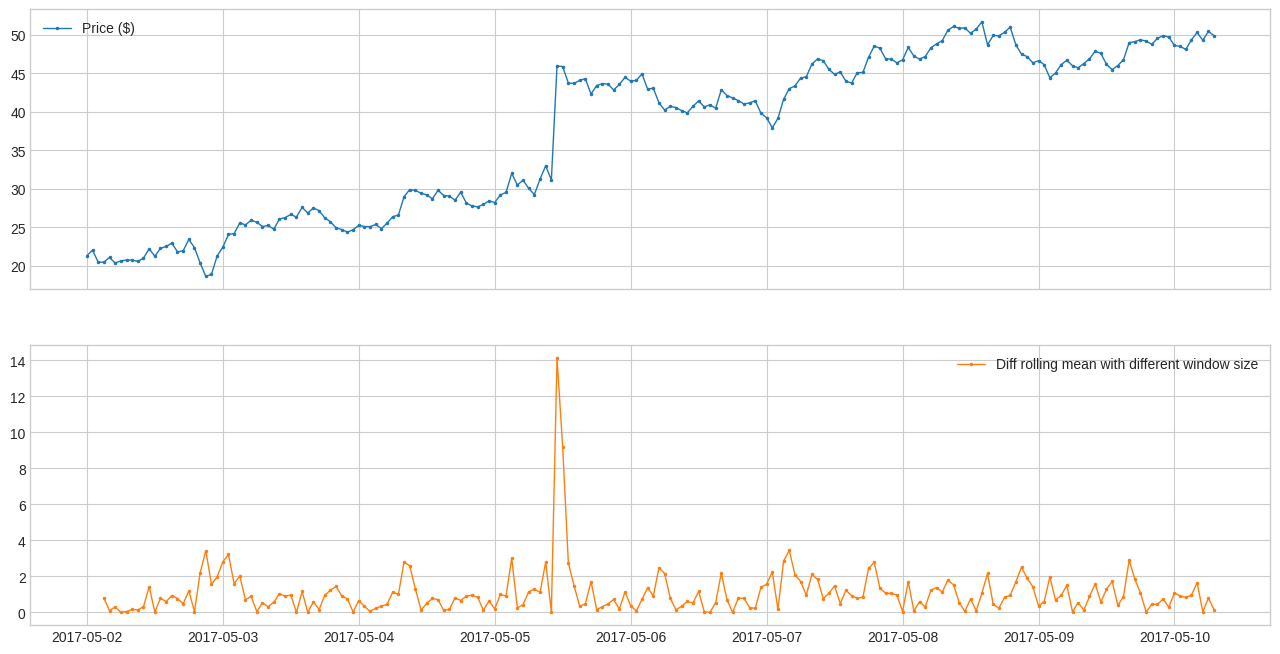

In [ ]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="mean",
    window=(3,1), #The tuple specifies the left window to be 3, and right window to be 1
    diff="l1").transform(s).rename("Diff rolling mean with different window size")

plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=3);

3. ClassicSeasonalDecomposition

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/seasonal.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

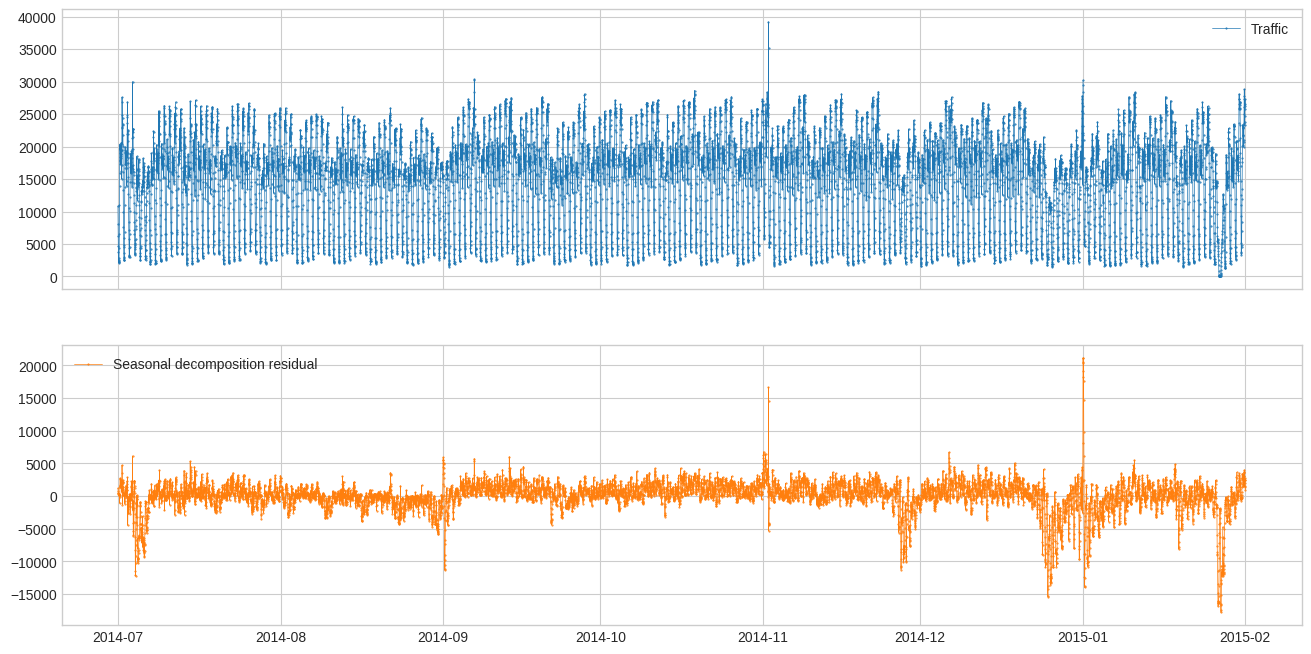

In [ ]:
from adtk.transformer import ClassicSeasonalDecomposition
s_transformed = ClassicSeasonalDecomposition().fit_transform(s).rename("Seasonal decomposition residual")
plot(pd.concat([s, s_transformed], axis=1), ts_markersize=1);

без извлечения тренда невозможно обрабатывать случаи, когда долгосрочный тренд смешивается с сезонной компонентой, а также с шумом. В таких случаях следует включить опцию trend

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/seasonal+trend.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)

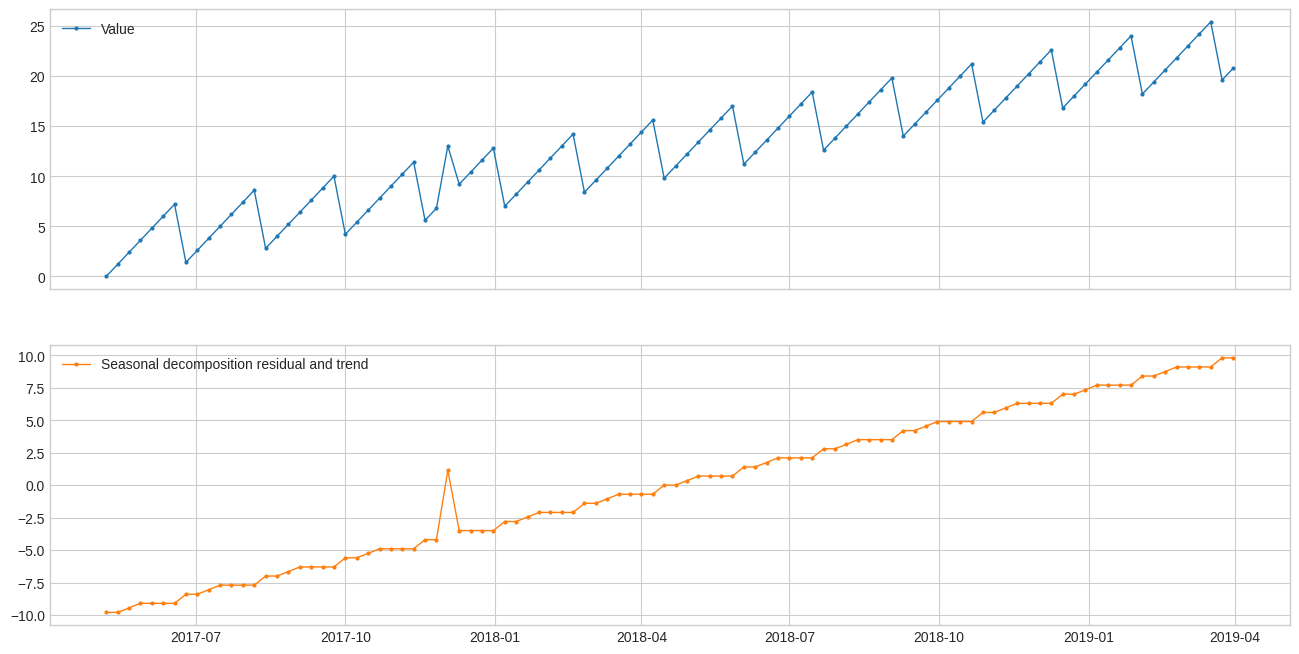

In [ ]:
s_transformed = ClassicSeasonalDecomposition(freq=7).fit_transform(s).rename("Seasonal decomposition residual and trend")
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=4);

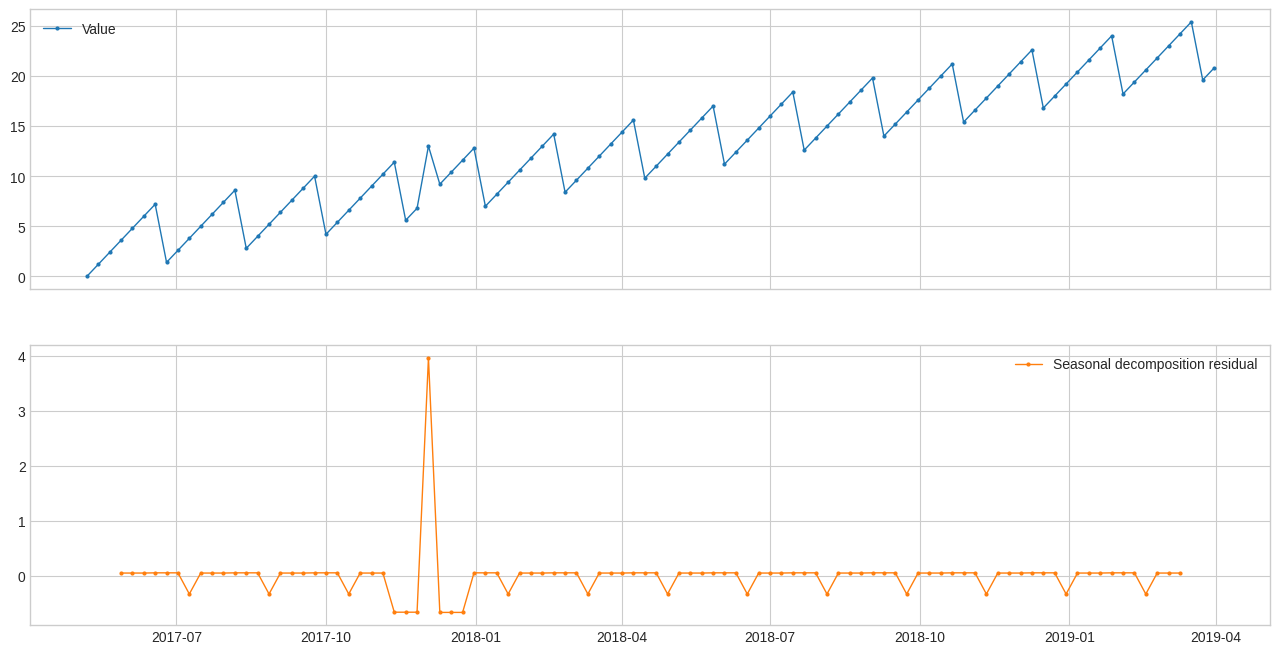

In [ ]:

s_transformed = ClassicSeasonalDecomposition(freq=7, trend=True).fit_transform(s).rename("Seasonal decomposition residual")
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=4);

4. Pipeline

Комплексирование методов выделения аномалий

In [ ]:
from adtk.pipe import Pipeline
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.995, low=0.005))
]
pipeline = Pipeline(steps)

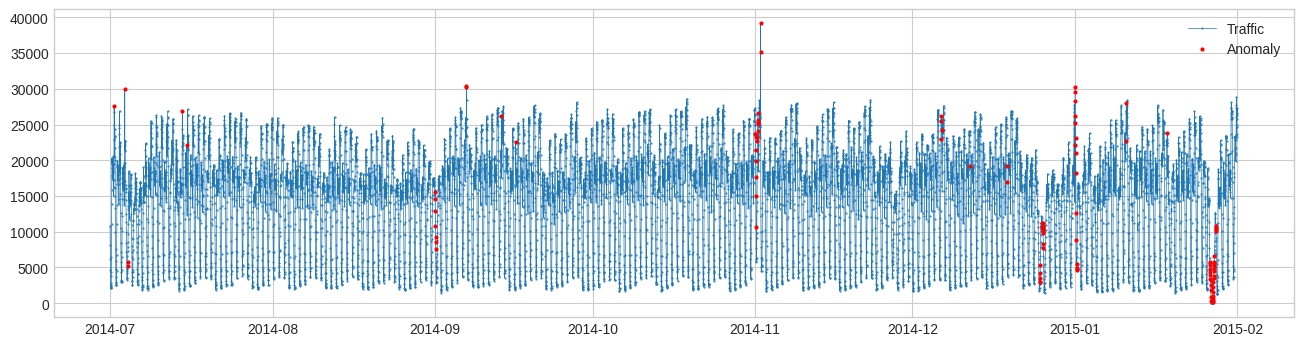

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/seasonal.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

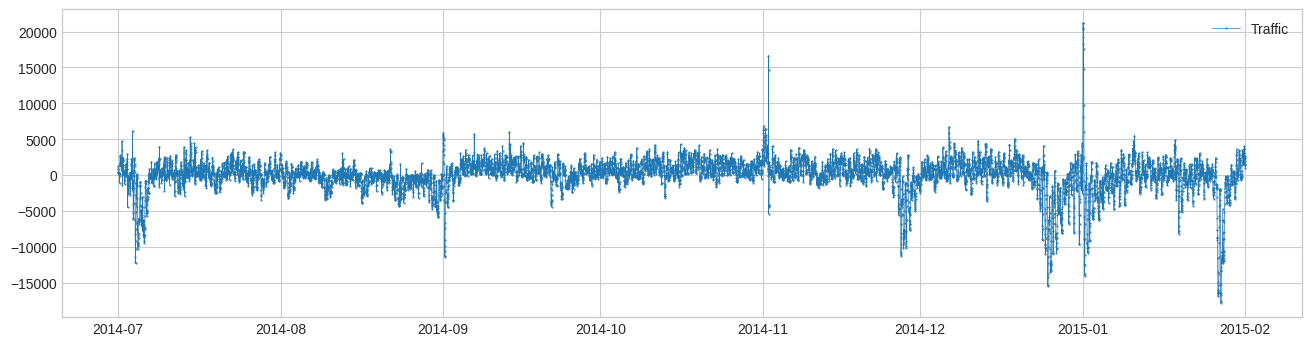

In [ ]:
results = pipeline.fit_detect(s, return_intermediate=True)
plot(results["deseasonal"], ts_markersize=1);

5. Pipenet - для НЕпоследовательной комбинации

In [ ]:
from adtk.pipe import Pipenet
from adtk.aggregator import AndAggregator
steps = {
    "abs_level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="l1"
        ),
        "input": "original"
    },
    "level_shift": {
        "model": InterQuartileRangeAD(c=3.0),
        "input": "abs_level_change"
    },
    "level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="diff"
        ),
        "input": "original",
    },
    "positive_level_change": {
        "model": ThresholdAD(high=0),
        "input": "level_change"
    },
    "positive_level_shift": {
        "model": AndAggregator(),
        "input": ["level_shift", "positive_level_change"]
    }
}
pipenet = Pipenet(steps)

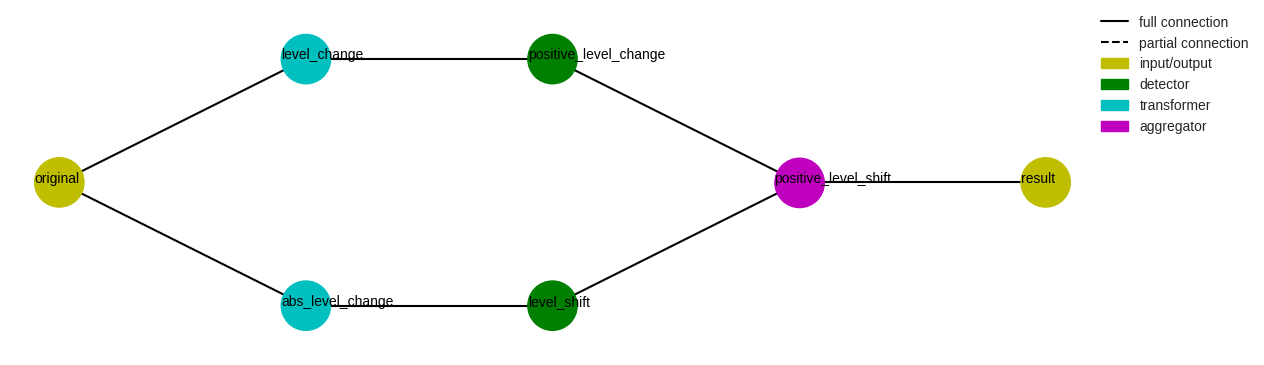

In [ ]:
pipenet.plot_flowchart();

In [ ]:
pipenet.get_params()


{'abs_level_change': {'window': 10,
  'agg': 'median',
  'agg_params': None,
  'center': True,
  'min_periods': None},
 'level_shift': {'c': 3.0},
 'level_change': {'window': 10,
  'agg': 'median',
  'agg_params': None,
  'center': True,
  'min_periods': None},
 'positive_level_change': {'low': None, 'high': 0},
 'positive_level_shift': {}}

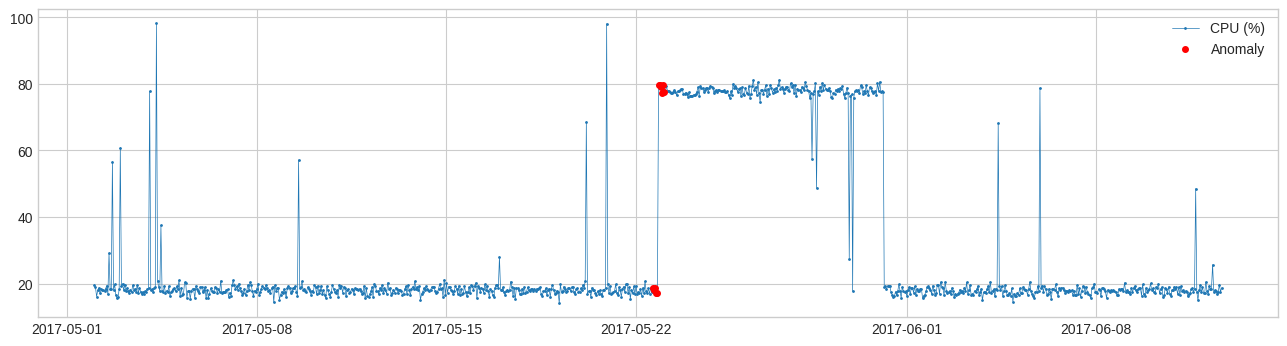

In [ ]:
s = pd.read_csv('https://github.com/arundo/adtk/raw/develop/docs/notebooks/data/cpu.csv', index_col="Time", parse_dates=True).squeeze('columns')
s = validate_series(s)
anomalies = pipenet.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red', anomaly_tag="marker");

пользователь имеет возможность получать промежуточные ряды и списки аномалий

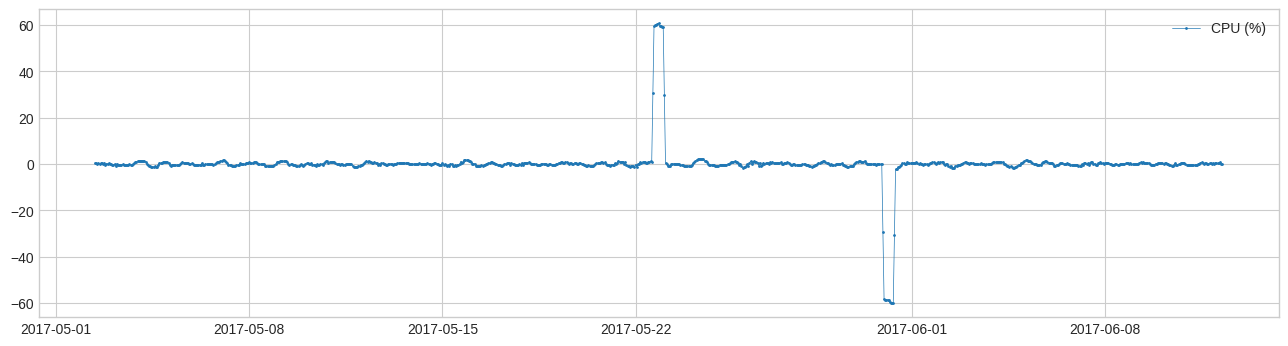

In [ ]:
results = pipenet.fit_detect(s, return_intermediate=True)
plot(results["level_change"]);

CUSUM Anomaly Detection (CAD)

In [ ]:
pip install pyanom

In [ ]:
from pyanom.outlier_detection import CAD

In [ ]:
y_normal = np.loadtxt(
   "https://raw.githubusercontent.com/ground0state/pyanom/master/demo/data/timeseries_normal.csv", delimiter=",").reshape(-1, 1)
y_error = np.loadtxt(
   "https://raw.githubusercontent.com/ground0state/pyanom/master/demo/data/timeseries_error.csv", delimiter=",").reshape(-1, 1)


print(y_normal.shape)
print(y_error.shape)


(100, 1)
(100, 1)


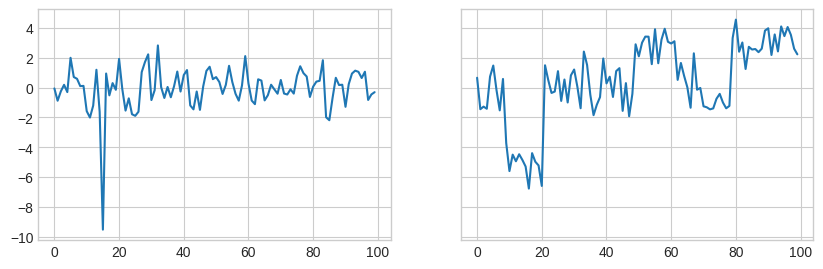

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

ax[0].plot(y_normal)
ax[1].plot(y_error)
plt.show()

In [ ]:
model = CAD(threshold=1.0) #
model.fit(y_normal)

CAD(threshold=1.0)

In [ ]:
anomaly_score = model.score(y_error)

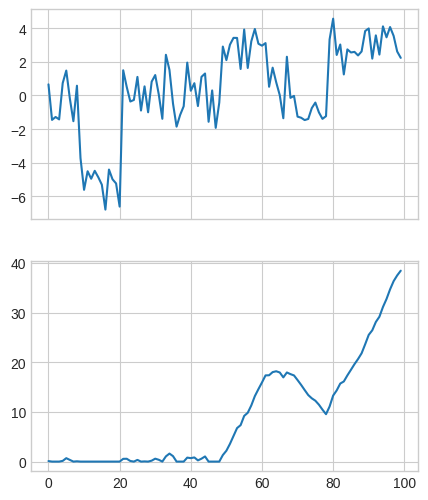

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 6), sharex=True)
ax[0].plot(y_error)
ax[1].plot(anomaly_score)
plt.show()